---

[![proyecto-final](https://github.com/AndresFelipeMunozAguilar/Proyecto_Final_IA1_UIS/blob/main/notebooks/figures/High%20Quality%20Banner%20Multimodal%20Early%20Detection%20of%20Parkinson's%20Disease.png?raw=true)](https://github.com/AndresFelipeMunozAguilar/Proyecto_Final_IA1_UIS)

In [ ]:
#@title **Instalar paquetes necesarios**
%%capture
! pip install torchmetrics
! pip install torchinfo

In [ ]:
#@title **Importar librerías**

# Manipulación de datos
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from zipfile import ZipFile

# Para la visualización de frames de los vídeos
from ipywidgets import widgets, IntSlider, interactive

# Nos permite reproducir audios y vídeos en el Notebook
import IPython.display as ipd

# Para tratar con audios
import librosa
from sklearn.preprocessing import minmax_scale # Para un proceso de normalización

# Utils
from tqdm import tqdm

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

# Pytorch essentials for datasets.
from torch.utils.data import Dataset, DataLoader

# Pytorch metrics
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryRecall, BinaryPrecision

# Utils
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [ ]:
#@title **Funciones de visualización necesarias**

# Para audio
def show_waveplot(audio_path,label):
    x , sr = librosa.load(audio_path, sr = 48000)
    plt.figure(figsize=(20, 6))
    librosa.display.waveshow(x, sr=sr)
    plt.title(f"Waveplot: of Class: {label}")

def show_spectrogram(audio_path,label):
    x , sr = librosa.load(audio_path, sr = 48000)
    # The STFT represents a signal in the time-frequency domain by computing
    # discrete Fourier transforms (DFT) over short overlapping windows.
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(20,6))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma')
    plt.colorbar()
    plt.title(f"Spectrogram of Class: {label}")

def show_zcr(audio_path,label):
    x , sr = librosa.load(audio_path, sr = 48000)
    zero_crossings = librosa.zero_crossings(x)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(20, 5))
    plt.title(f'Zero Crossing Rate of Class: {label}')
    zcrs = librosa.feature.zero_crossing_rate(x)
    plt.plot(zcrs[0])
    plt.show()

def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

def show_spectral_centroids(audio_path,label):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Centroids of Class: {label}')
    x , sr = librosa.load(audio_path, sr = 48000)
    spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.show()

def show_spectral_rolloff(audio_path,label):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Rolloff of Class: {label}')
    x , sr = librosa.load(audio_path, sr = 48000)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr, roll_percent=0.01)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.show()

def show_mfccs(audio_path,label):
    plt.figure(figsize=(20, 6))
    plt.title(f'MFCC of Class: {label}')
    x , sr = librosa.load(audio_path, sr = 48000)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

def show_melspectro(audio_path,label):
    plt.figure(figsize=(20, 6))
    plt.title(f'Mel Spectro of Class: {label}')
    x , sr = librosa.load(audio_path, sr = 48000)
    melspectro = librosa.feature.melspectrogram(y=x, sr=sr)
    librosa.display.specshow(melspectro, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

# <a name="tema1"> <font color='#4C5FDA'>**0. Comprendiendo el problema a tratar**</font> </a>

Logramos obtener un conjunto de datos de un conjunto de pacientes diagnosticados con Parkinson y pacientes de control.

La  <font color= "52F17F"> **enfermedad de Parkinson (EP)** </font> es una enfermedad neurodegenerativa crónica sin cura, caracterizada por una degeneración progresiva de las células nerviosas, disminuyendo la producción de dopamina, lo que resulta en graves alteraciones en el control del movimiento y la coordinación.

Las alteraciones motoras tempranas suelen manifestarse como <font color="EB9A54">**disartria**</font> (afectación del habla asociada a rigidez de los músculos).

<center>
  <img src="https://i.ytimg.com/vi/gD80xdT_uLE/maxresdefault.jpg" width="600" height="400">
</center>

E <font color="EB9A54">**hipomimia**</font> (afectación de la expresión facial asociada a lentitud de movimientos y rigidez).

<center>
  <img src="https://www.researchgate.net/publication/366948916/figure/fig1/AS:11431281160183154@1684634013197/Facial-expression-based-model-of-the-iPrognosis-app-for-detection-of-hypomimia-and.jpg" width="600" height="400">
</center>

Los pacientes con estos síntomas pueden experimentar dificultades para articular palabras o cambiar el tono de voz, lo que resulta en un habla difícil y monótona. Estos síntomas se manifiestan entre 7 y 11 años antes del diagnóstico de Parkinson. Hoy en día, estos patrones se caracterizan únicamente por pruebas observacionales, que dependen en gran medida de la experiencia del especialista.

La pregunta a responder es cómo podemos utilizar técnicas de análisis de video y audio para identificar patrones distintivos en los síntomas motores, como la rigidez facial y los trastornos del habla, y así desarrollar un enfoque multimodal que permita una detección precoz y precisa de la enfermedad, mejorando la calidad de vida de los pacientes y facilitando la planificación de tratamientos oportunos.

# <font color='#4C5FDA'> **1. ¡Exploremos nuestros datos! 😎**</color> <a name="tema2">


## <font color='#EB9A54'>**1.1 Carga de los datos**</font> <a name = "tema3">

<font color="52F17F">**Acerca del Dataset**</font>

La información recolectada por John se encuentra en carpetas separando entre paciendes de control y parkinson. En total se tienen 7 pacientes de control y 7 parkinson.

Para cada paciente se tienen vídeos con audio en los que las personas pronunciaron fonemas, vocales y palabras. La etiqueta ("yes" o "no" depediendo de si la persona tiene Parkison o es paciente de control) se obtiene a partir de la carpeta donde esté el registro.

Un <font color= "EB9A54"> **fonema** </font> es la unidad mínima de sonido que puede distinguir una palabra de otra en un lenguaje dado. En disartria, se estudian los patrones de producción y articulación de estos sonidos para detectar posibles alteraciones en el habla.

<font color='#52F17F'>**Lectura del Dataset**</font>

En el directorio `AudioVisualData_v7` podemos encontrar los vídeos para cada uno de los pacientes separada en casos con parkinson e imágenes de control. El cual tiene la siguiente estructura:

```
AudioVisualData_v7/
...Control/
......C0/
.........Phonemes/
............audio/
...............C0-1-Pakata.mp3
............frames/
...............C0-1-Pakata.mov/
..................000001.jpg
.........Vowels/
............audio/
...............C0-1-A.mp3
............frames/
...............C0-1-A.mov/
..................000001.jpg
.........Words/
............audio/
...............C0-1-Acariciar.mp3
............frames/
...............C0-1-Acariciar.mov/
..................000001.jpg
...Parkinson/
......P0/
.........Phonemes/
............audio/
...............P0-1-Pakata.mp3
............frames/
...............P0-1-Pakata.mov/
..................000001.jpg
.........Vowels/
............audio/
...............P0-1-A.mp3
............frames/
...............P0-1-A.mov/
..................000001.jpg
.........Words/
............audio/
...............P0-1-Acariciar.mp3
............frames/
...............P0-1-Acariciar.mov/
..................000001.jpg
```

Con `OS` y conociendo la estructura de nuestro dataset podemos armar un DataFrame de `pandas` para su análisis:


In [ ]:
#@title **Cargamos los datos desde Drive**

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/data_parkinson')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1XRruCPRodR4OhRCRZYKsyODqa_GuBkfC/data_parkinson


In [ ]:
#@title **Extraer el zip**

os.mkdir('../../../../data')
os.popen('cp data.csv ../../../../data/data.csv')
target_path = os.path.join('../../../../data') # Aquí es donde van a quedar los datos
# deben quedar fuera de drive para poder acceder a ellos 'localmente'

# Unzip the downloaded files
zip_file_path = os.path.join('AudioVisualData_v7.zip')
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_path)

# # Me muevo hasta donde quedaron los datos
%cd ../../../../data
# Verifico
%ls

In [ ]:
#@title **DataFrame con todos los registros**

# Directorio principal
main_directory = "AudioVisualData_v7"

patients = []
labels = []
frames = []
audios = []

"""
Esta construcción del dataset depende de la estructura del mismo
"""

# Itero por cada tipo de paciente: Control, Parkinson
for patient_type in os.listdir(main_directory):

  # A la ruta del directorio le concateno el tipo de paciente
  patient_type_path = os.path.join(f"{main_directory}/{patient_type}")

  # Itero por cada paciente en cada tipo de paciente
  for patient in os.listdir(patient_type_path):

    # A la ruta del tipo de paciente le concateno el paciente
    audio_type_path = os.path.join(f"{patient_type_path}/{patient}")

    # Itero por el tipo de sample: Phonemes, Vowels, Words
    for sample_type in os.listdir(audio_type_path):

      # Armo la ruta hasta el tipo de sample
      file_type_path = os.path.join(f"{audio_type_path}/{sample_type}")

      # Itero por cada registro en cada tipo de sample y le anaño audio a la ruta
      # para que entre de una vez a los registros
      for record in os.listdir(f"{file_type_path}/audio"):

        # Armo la ruta hasta el registro
        record_path = os.path.join(f"{file_type_path}/audio/{record}")
        # Agrego el paciente a la lista de pacientes
        patients.append(patient)
        # Agrego el label al final para asegurar que lo haga para cada paciente
        if patient_type == 'Parkinson':
          labels.append(1.)
        else:
          labels.append(0.)
        # Agrego la ruta del video
        frames.append(record_path.replace('audio', 'frames').replace('.mp3', '.mov'))
        # Agrego la ruta del audio
        audios.append(record_path)

# Crear un DataFrame con la información
data = pd.DataFrame({
    'patient': patients,
    'audio_path': audios,
    'frames_path': frames,
    'label': labels
})

data.set_index('patient', inplace=True)
data.head()

,audio_path,frames_path,label
patient,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0


## <font color='#EB9A54'>**1.2 Limpieza de los datos**</font> <a name = "tema3">

In [ ]:
#@title Código para renombrar archivos que no coinciden con el paciente el ID
def rename_files_based_on_id(base_path):
    """
    Rename audio and frame files based on the correct patient ID.

    Args:
    - base_path (str): Path to the root directory of the dataset.

    Returns:
    - None
    """

    # Lista de pacientes con IDs incorrectos
    correct_ids = ['C4', 'C5', 'C6']

    # Iterar sobre los pacientes
    for patient_type in ['Control', 'Parkinson']:
      for correct_id in correct_ids:

          # Construir las rutas originales
          original_path = os.path.join(base_path, patient_type, correct_id)

          # Verificar si el directorio existe
          if not os.path.exists(original_path):
              print(f"No directory found for {correct_id} in {patient_type}.")
              continue

          # Obtener el ID correcto para el paciente
          correct_id = f"{patient_type[0]}{int(correct_id[1:])}"

          # Construir la ruta del nuevo directorio
          new_path = os.path.join(base_path, patient_type, correct_id)


          # # Renombrar los directorios
          # os.rename(original_path, new_path)

          # print(f"Renamed {patient_type} directory from {incorrect_id} to {correct_id}.")

          # Iterar sobre las categorías (Phonemes, Vowels, Words)
          for category in ['Phonemes', 'Vowels', 'Words']:

              original_category_path = os.path.join(new_path, category)

              # Verificar si el directorio de la categoría existe
              if not os.path.exists(original_category_path):
                  print(f"No {category} directory found for {correct_id}.")
                  continue

              # Iterar sobre los archivos en la carpeta original
              for file_type in os.listdir(original_category_path):

                  # Construir los nombres de los archivos originales y nuevos
                  original_file_path = os.path.join(original_category_path, file_type)
                  # new_file_name = file_name.replace(incorrect_id, correct_id)
                  # new_file_path = os.path.join(original_category_path, incorrect_id)
                  for file_name in os.listdir(original_file_path):
                    actual_file_name_path = os.path.join(original_file_path, file_name)
                    new_file_name = file_name.replace(file_name[:2], correct_id)
                    new_file_name_path = os.path.join(original_file_path, new_file_name)
                    # print(f"{actual_file_name_path} - {new_file_name_path}")

                  # Renombrar los archivos
                    os.rename(actual_file_name_path, new_file_name_path)

                    print(f"Renamed {category} file from {file_name} to {new_file_name}.")

# Llamar a la función para corregir los nombres de los archivos
rename_files_based_on_id("AudioVisualData_v7")

Renamed Phonemes file from C4-2-Pakata.mp3 to C4-2-Pakata.mp3.
Renamed Phonemes file from C4-2-Petaka.mp3 to C4-2-Petaka.mp3.
Renamed Phonemes file from C4-2-Pataka.mp3 to C4-2-Pataka.mp3.
Renamed Phonemes file from C4-3-Petaka.mp3 to C4-3-Petaka.mp3.
Renamed Phonemes file from C4-3-Pataka.mp3 to C4-3-Pataka.mp3.
Renamed Phonemes file from C4-1-Pakata.mp3 to C4-1-Pakata.mp3.
Renamed Phonemes file from C4-1-Pataka.mp3 to C4-1-Pataka.mp3.
Renamed Phonemes file from C4-1-Petaka.mp3 to C4-1-Petaka.mp3.
Renamed Phonemes file from C4-3-Pakata.mp3 to C4-3-Pakata.mp3.
Renamed Phonemes file from C4-3-Pataka.mov to C4-3-Pataka.mov.
Renamed Phonemes file from C4-3-Petaka.mov to C4-3-Petaka.mov.
Renamed Phonemes file from C4-3-Pakata.mov to C4-3-Pakata.mov.
Renamed Phonemes file from C4-1-Petaka.mov to C4-1-Petaka.mov.
Renamed Phonemes file from C4-2-Pakata.mov to C4-2-Pakata.mov.
Renamed Phonemes file from C4-2-Pataka.mov to C4-2-Pataka.mov.
Renamed Phonemes file from C4-2-Petaka.mov to C4-2-Peta

## <font color='#EB9A54'>**1.3 Visualización de los datos**</font> <a name = "tema3">

In [ ]:
#@title **Función para obtener una muestra**

def get_sample(tipo:float):

  sample = data[(data['label']==tipo)].sample(1)

  if tipo == 1.0:
    tipo = 'Parkinson'
  else:
    tipo = 'Control'
  sample = [sample['audio_path'].item(), sample['frames_path'].item(), tipo]
  return sample

In [ ]:
# Obtengo una muestra aleatoria para cada clase
parkinson = get_sample(1.0)
control = get_sample(0.0)

### <font color='#52F17F'>**Hipomimia (vídeos)**</font>

In [ ]:
def funcion(x, video_path: str):
    """
    Muestra una imagen específica de una secuencia de video.

    Args:
        x (int): El índice de la imagen en la secuencia de video. Se espera que las imágenes
                 estén nombradas secuencialmente con formato de seis dígitos, como '000001.jpg'.
        video_path (str): La ruta del directorio que contiene las imágenes de la secuencia de video.

    Returns:
        None: La función muestra la imagen especificada y el título de la imagen en una ventana de visualización.
    """

    # Cargar la imagen con el índice especificado, asegurando que el nombre del archivo tenga seis dígitos
    img = cv2.imread(f"{video_path}/"+"0"*(6-len(str(x)))+str(x)+".jpg")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(video_path.split('/')[-1])
    plt.show()

In [ ]:
#@title Muestra con hipomimia
slow = interactive(funcion, video_path=parkinson[1],x=widgets.IntSlider(min=1, max=100, step=1), continuous_update=True)
slow

In [ ]:
#@title Muestra sin hipomimia
slow = interactive(funcion, video_path=control[1],x=widgets.IntSlider(min=1, max=100, step=1), continuous_update=True)
slow

### <font color='#52F17F'>**Disartria (audios)**</font>

In [ ]:
#@title Muestra con disartria
ipd.Audio(parkinson[0])

In [ ]:
#@title Muestra sin disartria
ipd.Audio(control[0])

## <font color='#EB9A54'>**1.4 Análisis exploratorio**</font> <a name = "tema4">

### <a name = "tema5"> <font color="52F17F"> **1.2.1 Análisis del audio para la disartria** </font> </a>

Primero hay que definir algunas caracterísitcas descriptivas de las señales de sonido.

1. **Forma de onda (Waveform)**: Es una representación gráfica de una onda de sonido a medida que se mueve a través de un medio a lo largo del tiempo.

2. **Espectograma (Spectogram)**: Es una figura que representa el espectro de frecuencias de un audio grabado a lo largo del tiempo. Esto significa que a medida que el color de la figura se vuelve más brillante, el sonido se concentra en gran medida alrededor de esas frecuencias específicas, y a medida que el color se vuelve más oscuro, el sonido se acerca al sonido vacío/muerto.

3. **Tasa de cruce por cero (Zero crossing rate)**: La calificación de cruce por cero es el no. de veces que la señal cambia su valor de positivo a negativo o viceversa dividido por la longitud del cuadro.

4. **Centroide espectral (Spectral Centroid)**: Representa el centro de masa del espectro. Nos da la banda de frecuencia donde se concentra la mayor parte de la energía. Los centroides suelen estar altos cuando no hay voz y se vuelven bajos en aquellos casos en los que la voz está presente en el audio.

5. **Caída espectral (Spectral Roll-off)**: La caída espectral representa la frecuencia por debajo de la cual un cierto porcentaje (normalmente entre el 80 % y el 90 %, librosa: 85%) de la distribución de magnitud del espectro se concentra en el espectro.

6. **MFCC (Mel-frequency cepsral coefficients)**: Es una representación compacta del espectro de frecuencias de un audio. Se calcula en seis pasos y proporciona una representación de baja dimensión que captura las características más importantes del espectro de frecuencias.

<center>
  <img src="https://www.researchgate.net/publication/331275489/figure/fig2/AS:729006496292864@1550820101122/Steps-involved-in-MFCC-feature-extraction.png" width="600" height="400">
</center>

7. **Espectrograma Mel (Mel Spectrogram)**: Es un espectrograma donde las frecuencias se convierten a la escala Mel. La escala Mel muestra las magnitudes que son más perceptibles para el oído humano en general.

#### **Waveplots**


*   Para las muestra disártrica se puede observar que la muestra masculina tiene un habla arrastrada como es evidente en el diagrama de ondas.
*   Las muestras no disártricas tienen una gráfica de onda regular que indica un habla a un ritmo regular.



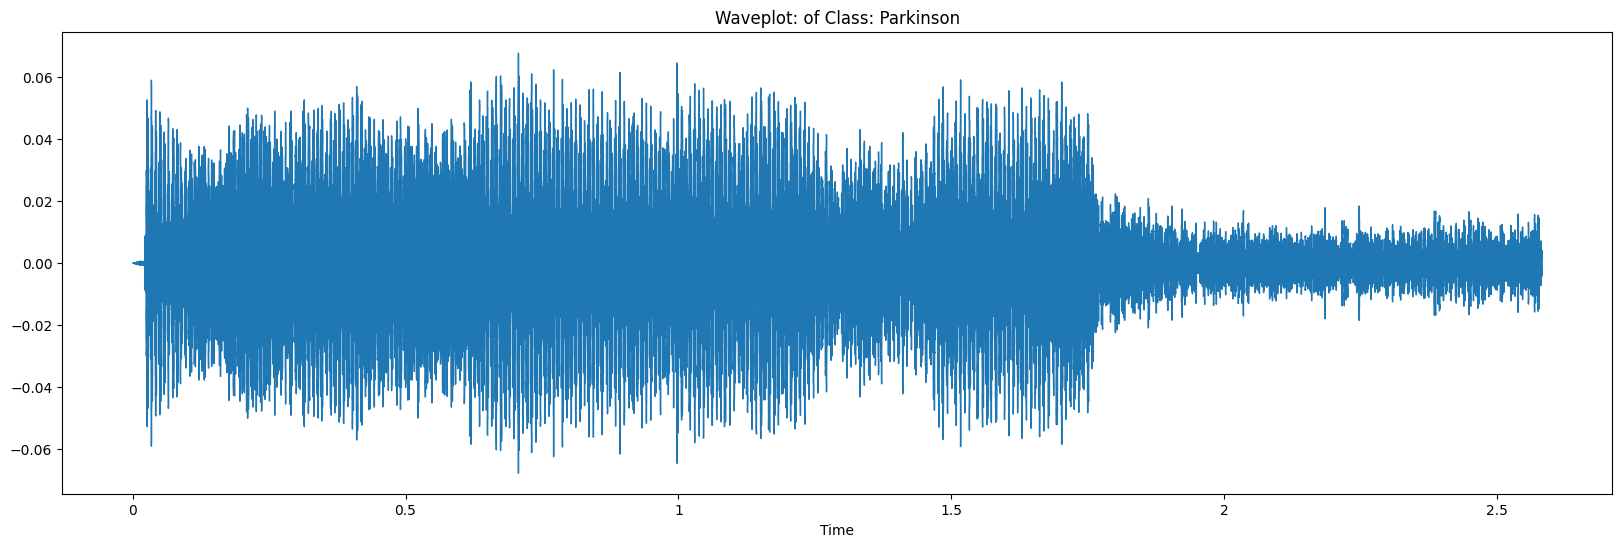

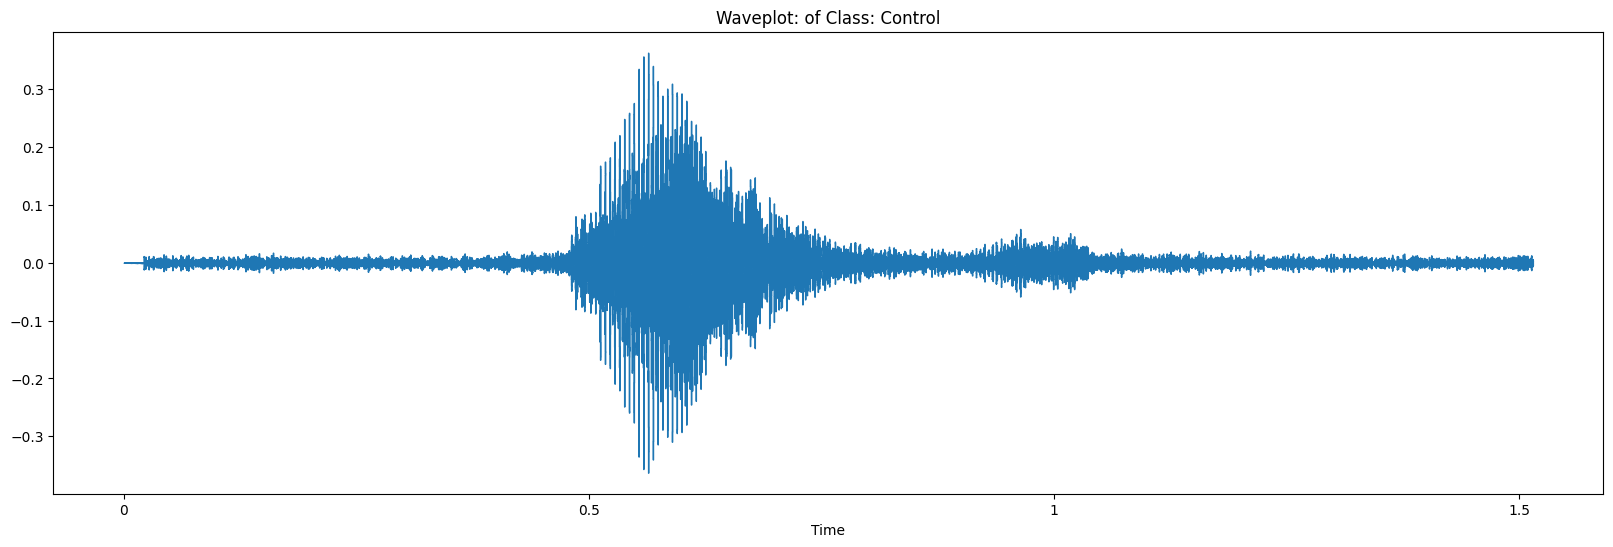

In [ ]:
show_waveplot(parkinson[0], parkinson[2])
show_waveplot(control[0], control[2])

#### **Spectrograms**


*   Para las muestras disártricas se puede ver que las magnitudes de energía de las frecuencias están más dispersas a lo largo del tiempo, lo que indica un habla lenta y confusa o debido al hecho de que las palabras salen más rápidamente y se superponen entre sí. También podrían ser posibles patrones similares para una persona disártrica y que habla de forma monótona.
*   Para las muestras no disártricas se puede ver que las magnitudes de energía están más reducidas a solo las partes donde han hablado algo, que es a un ritmo regular.



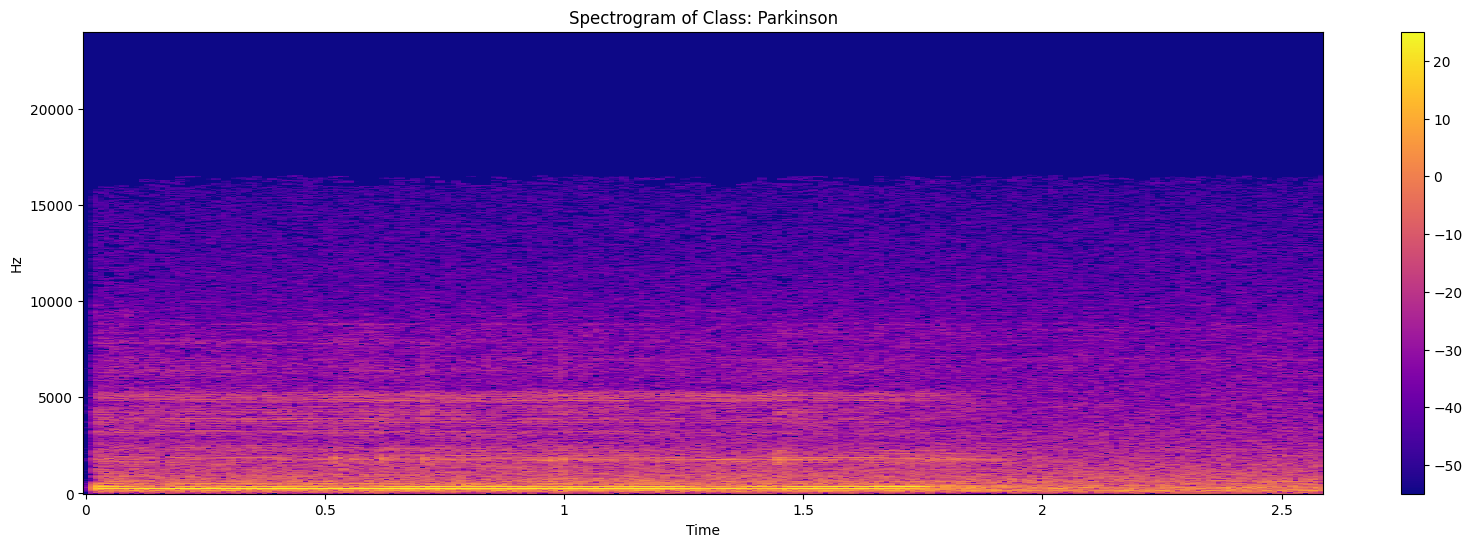

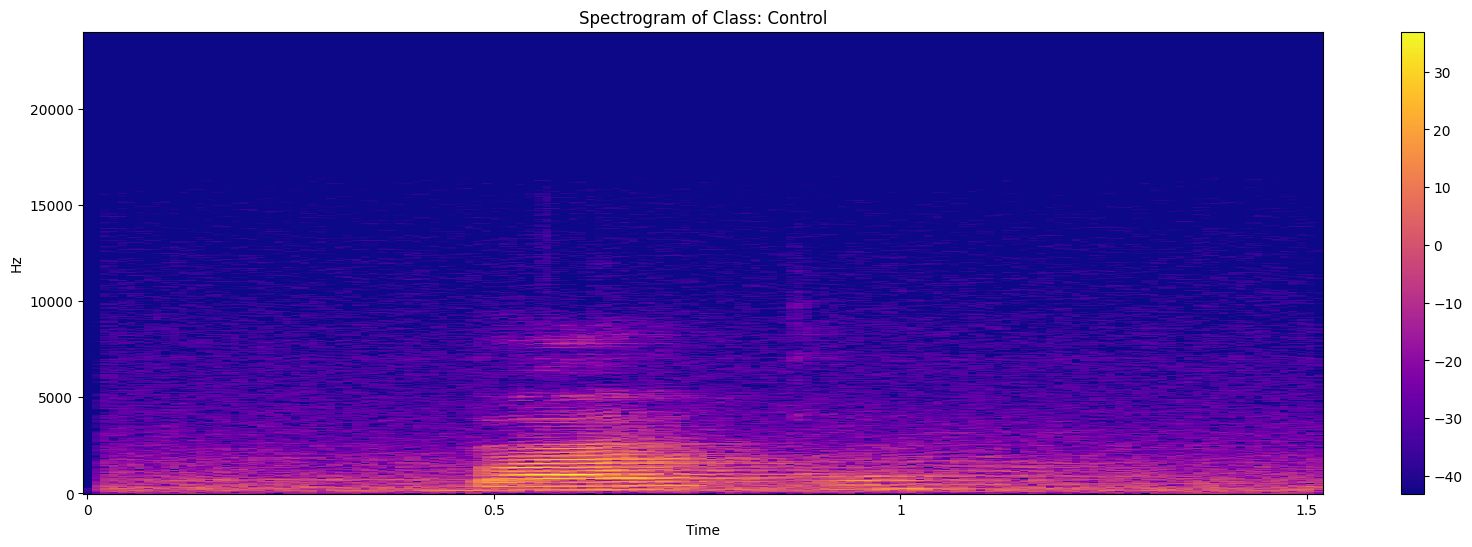

In [ ]:
show_spectrogram(parkinson[0], parkinson[2])
show_spectrogram(control[0], control[2])

#### **Zero Crossing Rate**


*   Para las muestras disártricas, se puede observar que en el audio mismo hubo casos en los que algunas de las frases de las palabras eran relativamente más fuertes y, por lo tanto, hay múltiples picos de tasa de cruce por cero en esos casos. Este volumen repentino de ciertas palabras podría deberse a su falta de control sobre la lengua y otros músculos relacionados con la boca mientras hablan y a no poder enfatizar las palabras intencionalmente.
*   Para los casos no disártricos, la tasa de cruce por cero es alta en aquellos casos en los que la voz del hablante es audible.



Sum of zero crossing  2672


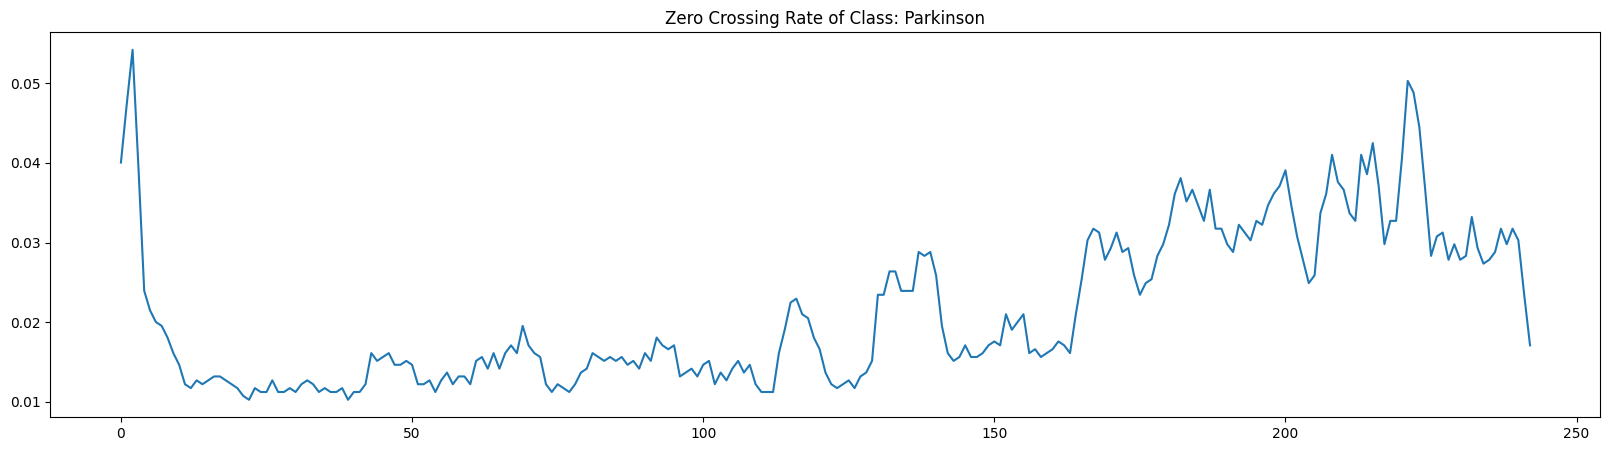

Sum of zero crossing  2617


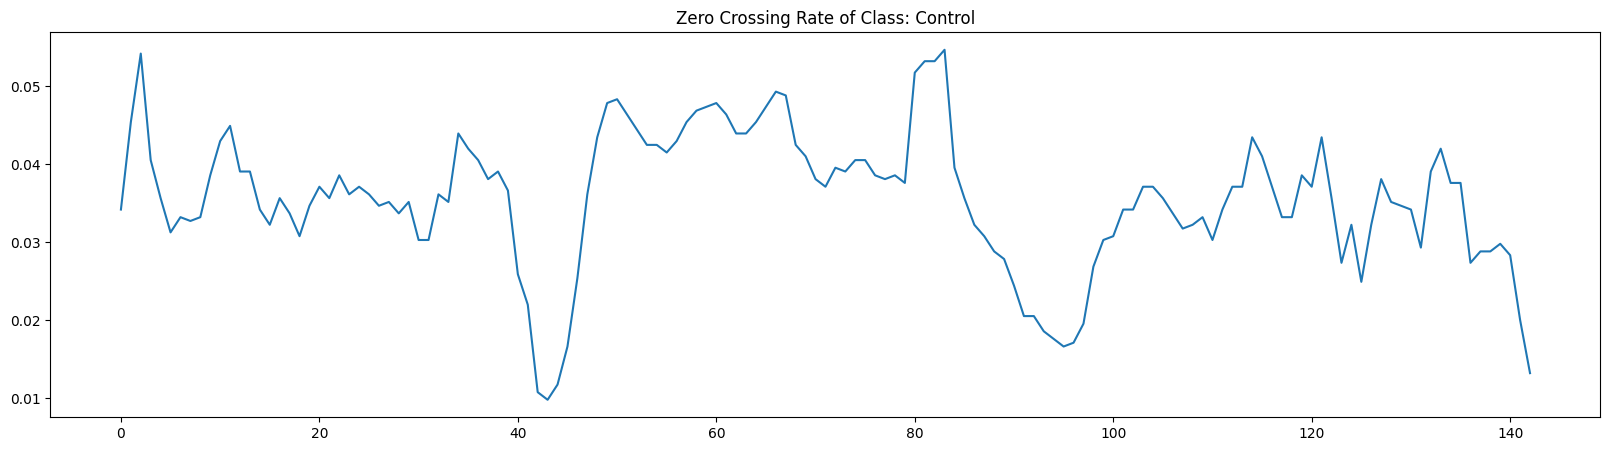

In [ ]:
show_zcr(parkinson[0], parkinson[2])
show_zcr(control[0], control[2])

#### **Spectral Centroid**


*   Para muestras disártricas se puede ver que debido a que el habla es confusa, los valores del centroide bajan por un tiempo y vuelven a subir tan pronto como hay algunas pequeñas pausas.
*   Para muestras no disártricas, los centroides están abajo por un momento cuando el habla está presente en el audio y vuelven a subir tan pronto como no hay voz en el audio.



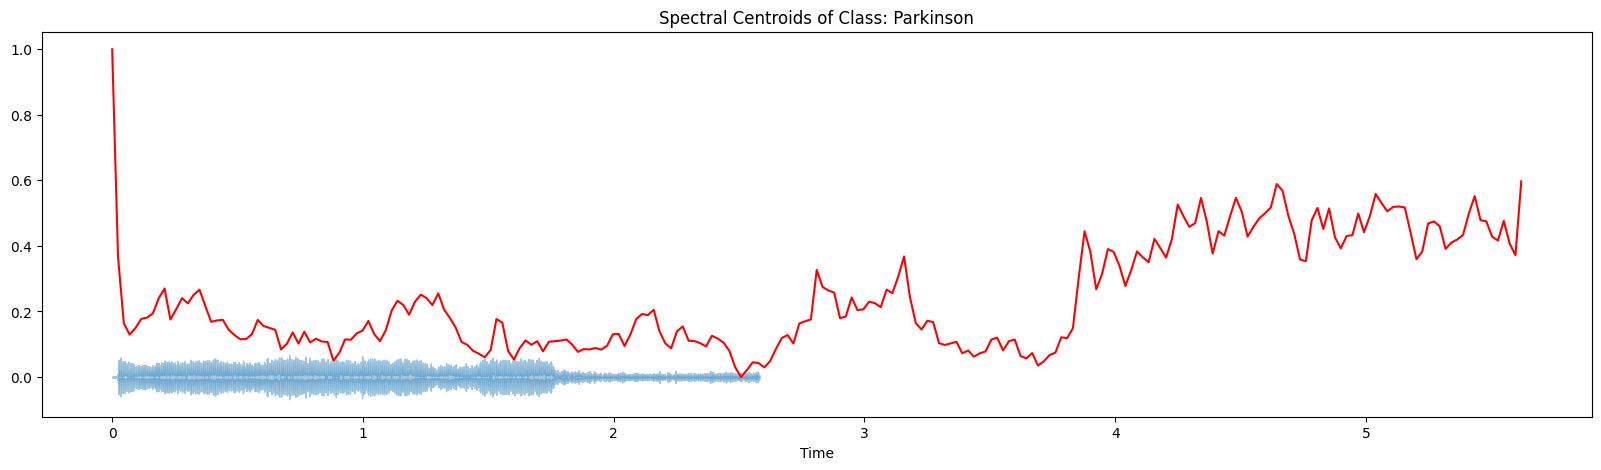

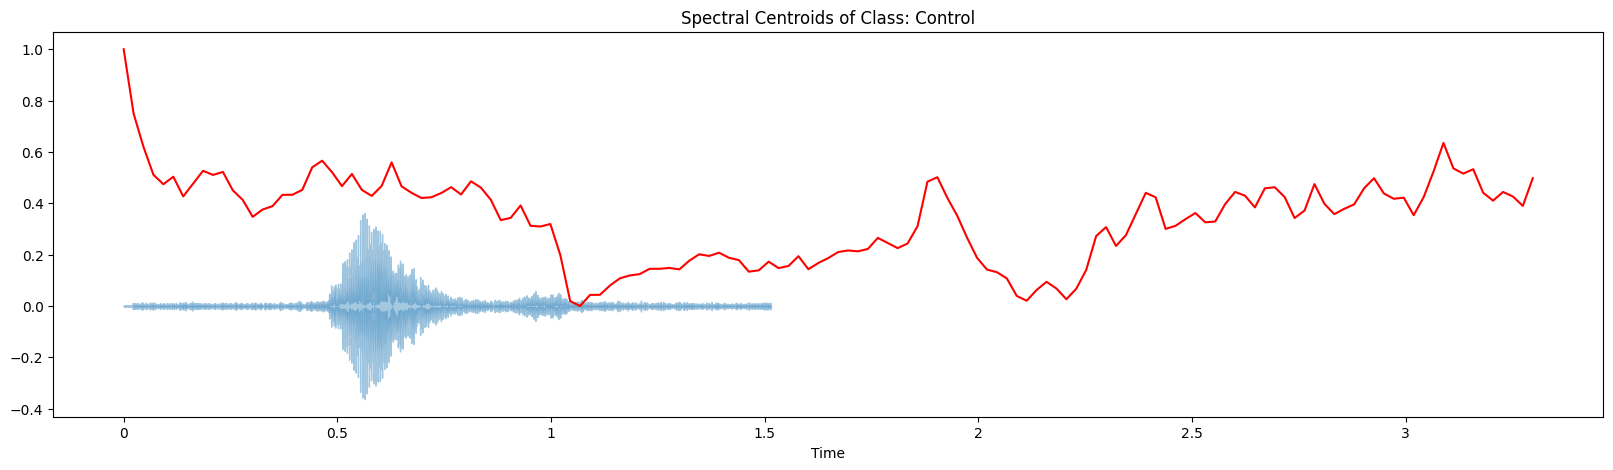

In [ ]:
show_spectral_centroids(parkinson[0], parkinson[2])
show_spectral_centroids(control[0], control[2])

#### **Spectral Rolloff**


*   Como habíamos observado anteriormente en los espectrogramas las magnitudes de energía de las frecuencias están más dispersas en el caso de muestras disártricas, se puede ver la cobertura del 85% por debajo de la frecuencia de caída envolviendo el habla presente en la señal de audio.
*   Para muestras no disártricas podemos ver que la cobertura del 85% incluye el habla así como algunas otras perturbaciones/ruido en el audio.



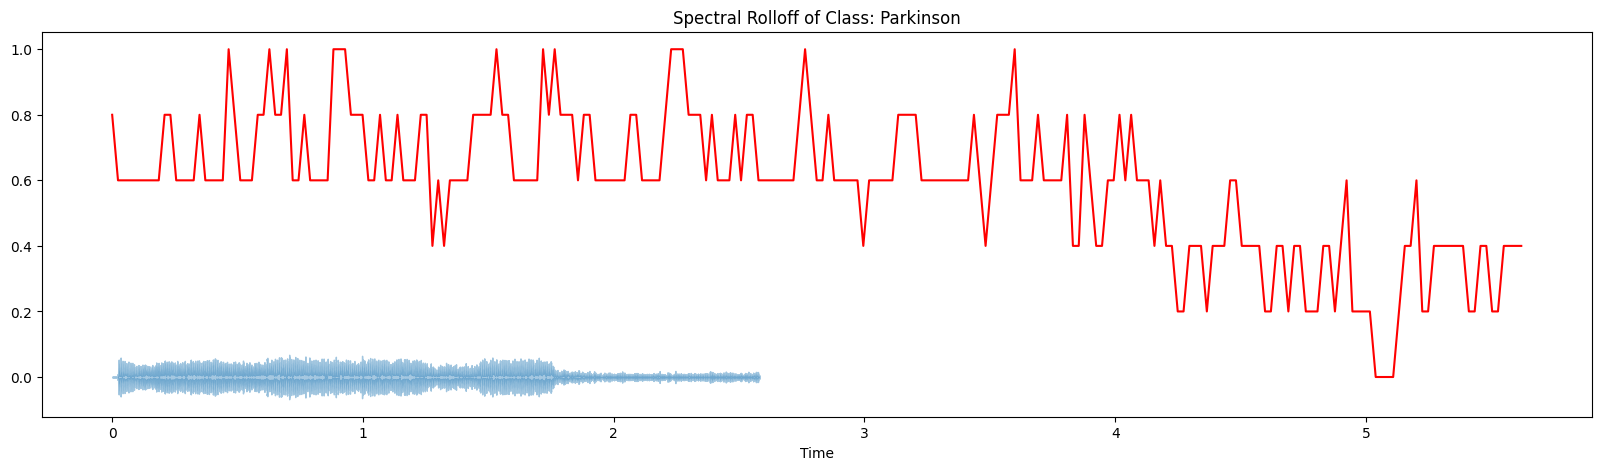

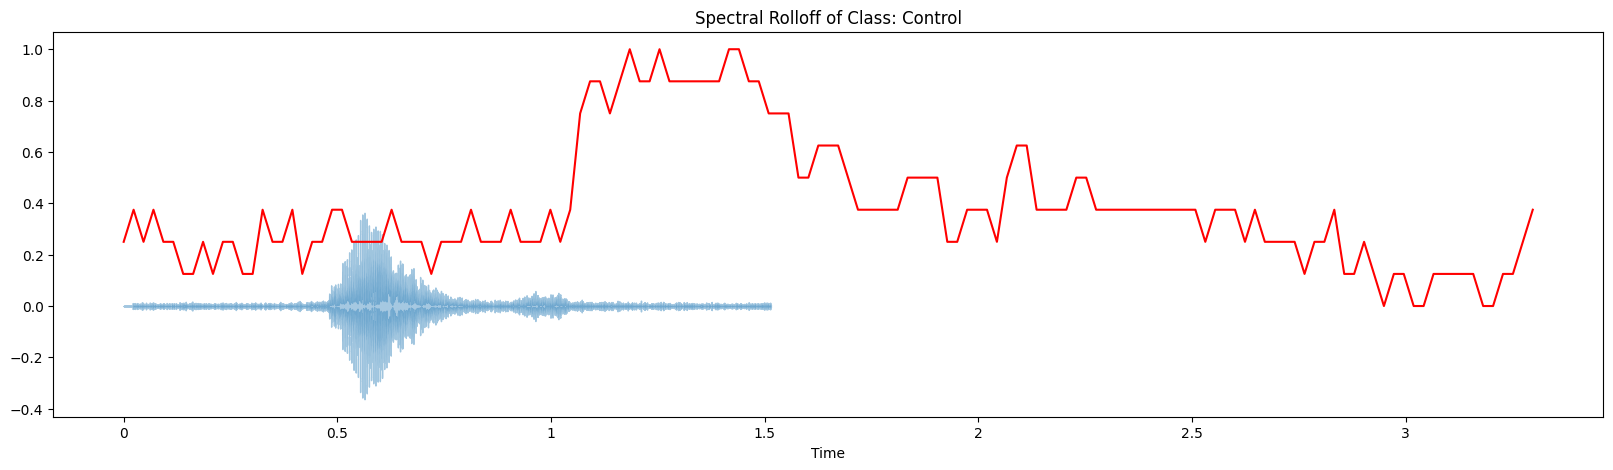

In [ ]:
show_spectral_rolloff(parkinson[0], parkinson[2])
show_spectral_rolloff(control[0], control[2])

#### **MFCCs**


*   Para muestras disártricas, la visualización de MFCC tiene píxeles mucho más oscuros y concentrados que indican los arrastres presentes en su habla.
*   Para los no disártricos no está tan concentrado y está más extendido.



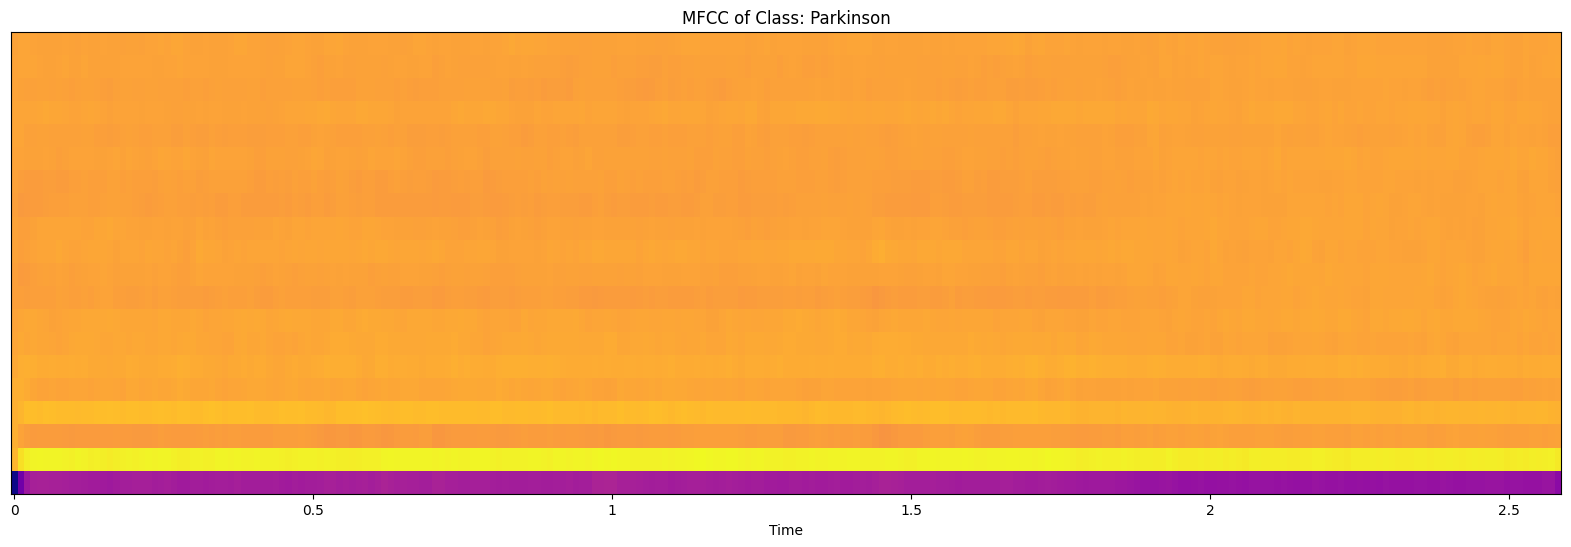

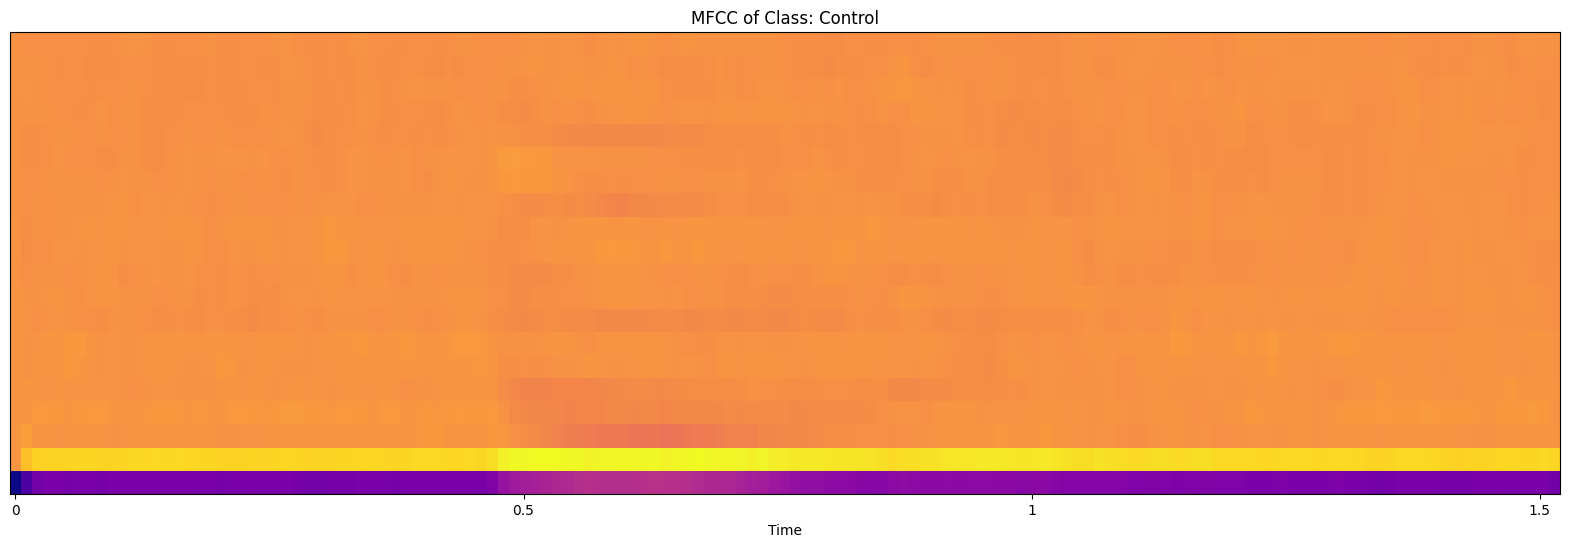

In [ ]:
show_mfccs(parkinson[0], parkinson[2])
show_mfccs(control[0], control[2])

#### **Mel Spectrogram**


*   Los patrones en los espectrogramas Mel de las muestras disártricas son algo indicativos de los arrastres en el habla.



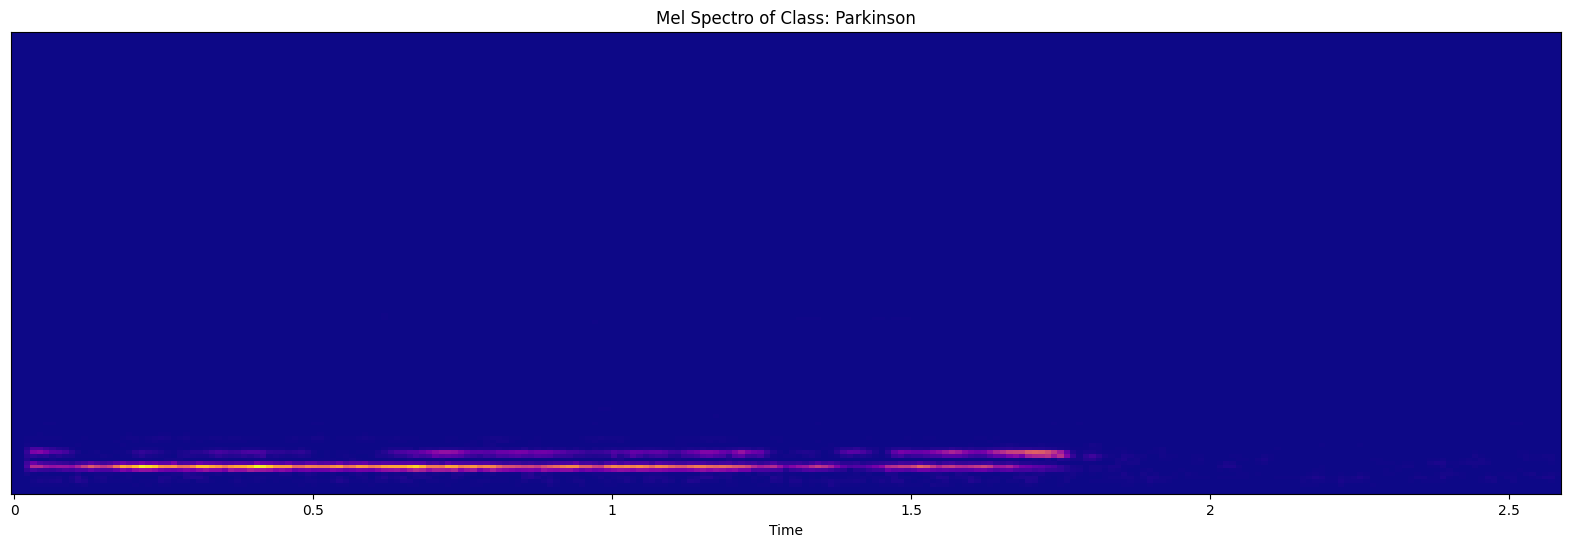

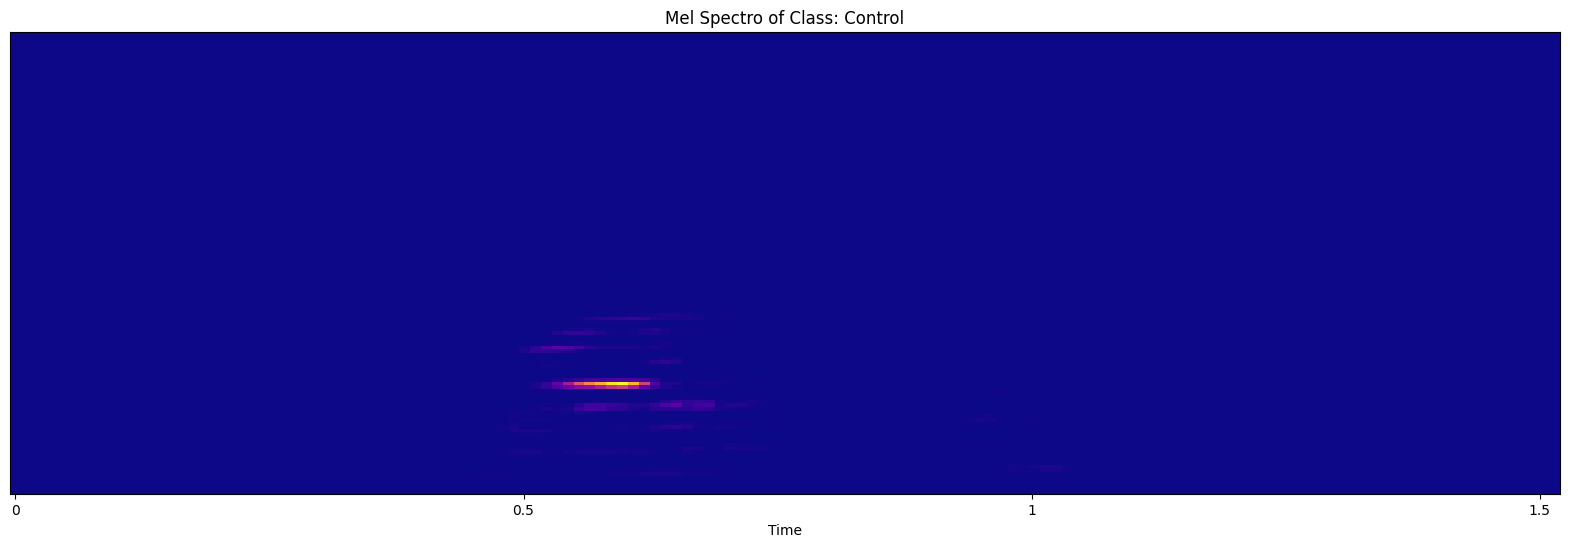

In [ ]:
show_melspectro(parkinson[0], parkinson[2])
show_melspectro(control[0], control[2])

### <font color="52F17F"> **1.2.2 Análisis de los frames para la hipomimia** </font> </font> <a name = "tema6">

Tamaño del sample con parkinson: (448, 348, 3)
Tamaño del sample de control: (621, 511, 3)


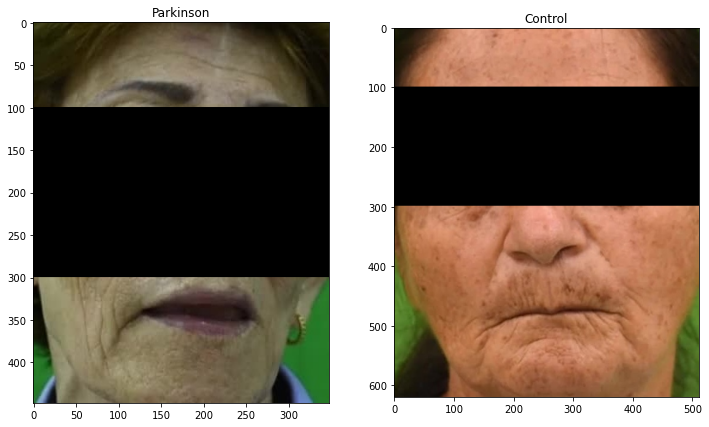

In [ ]:
#@title **Visualización de ambos frames**

# Parkinson
frame_parkinson = cv2.imread(f'{parkinson[1]}/000001.jpg')
frame_parkinson = cv2.cvtColor(frame_parkinson, cv2.COLOR_BGR2RGB)

# Control
frame_control = cv2.imread(f'{control[1]}/000001.jpg')
frame_control = cv2.cvtColor(frame_control, cv2.COLOR_BGR2RGB)

frame_parkinson[100:300,:,:] = 0
frame_control[100:300,:,:] = 0


print("Tamaño del sample con parkinson:", frame_parkinson.shape)
print("Tamaño del sample de control:", frame_control.shape)

plt.figure(figsize=(12, 7))
plt.subplot(1,2,1); plt.title(parkinson[2])
plt.imshow(frame_parkinson)
plt.subplot(1,2,2); plt.title(control[2])
plt.imshow(frame_control)
plt.show()

#  <font color='#4C5FDA'> **2. Preprocesamiento de los datos 🧐**</color> <a name="tema7">


## <a name = "tema8"><font color='#EB9A54'>**2.1 Extracción de caracterísitcas para la disartria**</font> </a>

El espectrograma Mel mapea frecuencias a una escala perceptualmente lineal, reflejando mejor la respuesta auditiva humana y destacando características relevantes para el reconocimiento de sonido, por esto, decidimos usarlo.

Este espectograma es una escala logarítmica basada en el principio de que distancias iguales en la escala tienen la misma distancia perceptiva.

<center>
  <img src="https://www.researchgate.net/publication/351469852/figure/fig1/AS:1022100571705347@1620699174717/The-process-of-extracting-the-Mel-spectrogram-from-an-acoustic-signal-where-the-output.png" width="600" height="400">
</center>

La conversión de frecuencia (f) a escala Mel (m) viene dada por: $m = 2595*log(1+\frac{f}{500})$

Un [espectrograma Mel](https://devopedia.org/audio-feature-extraction) es, por tanto, un espectrograma en el que las frecuencias se convierten a la escala Mel.

Por suerte, [librosa](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html) tiene la implementación del pipeline para conseguir los espectogramas MEL en una línea. Específicamente `librosa.feature.melspectrogram(y=x, sr=sr)` calcula un espectrograma a escala mel.

### <font color="52F17F">**Cantidad promedio de segundos por audio**</font>

In [ ]:
def get_mean_audio_duration(df):
    times = []

    for i, record in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            x, sr = librosa.load(record['audio_path'], sr=48000)
            time = librosa.get_duration(y=x, sr=sr)
            times.append(time)

        except EOFError:
            print(f'Error reading audio: {i}')
            pass

    return sum(times) / len(times)

In [ ]:
# Saco la media de duración de todos los aduios
SEGUNDOS_PROMEDIO = get_mean_audio_duration(data)

100%|██████████| 1091/1091 [00:04<00:00, 227.26it/s]


In [ ]:
print(f"{SEGUNDOS_PROMEDIO*0.1:.6f}")

0.239328


### <font color="52F17F">**Ejemplo con un sample y función de preprocesamiento**</font>

In [ ]:
"""
Constante sacada de la media de duración de todos los audios multiplicada por 0.1
para tener el 10%
"""
SEGUNDOS_PROMEDIO = 0.239328

In [ ]:
def preprocess_audio(audio:str):
  """
  Esta función calcula el espectograma mel en escala logarítmica de un audio
  con pasos de 25ms y una ventana de 40ms. Además usamos 90 bandas mel y un
  sampling rate de 48 kHz.

  Args:
    audio: path del audio
  Returns:
    log_mel_spectogram: An array of mel spectogram in the shape of (n_mels, n_frames).
  """
  samples, sample_rate = librosa.load(audio, sr = 48000, duration=SEGUNDOS_PROMEDIO)
  steps = int(25/(1/sample_rate*1000)) # Pasos de 25ms
  window = int(40/(1/sample_rate*1000)) # window (numero de samples por ventana) de 40ms

  # Encontramos el espectograma mel con 90 bandas.
  mel_spectogram = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_fft = window, hop_length=steps, n_mels = 90)

  # Lo movemos a escala logarítmica
  log_mel_spectogram = librosa.power_to_db(mel_spectogram)
  return log_mel_spectogram.flatten()

In [ ]:
sample_preprocessed_audio = preprocess_audio(get_sample(1.0)[0])

In [ ]:
sample_preprocessed_audio.shape

(900,)

In [ ]:
print(f"Un sample equivale a {1/48000*1000:.4f}ms")

Un sample equivale a 0.0208ms


In [ ]:
print(f"Un frame (usando ventanas de 40ms) tiene {40/(1/48000*1000)} samples")

Un frame (usando ventanas de 40ms) tiene 1920.0 samples


In [ ]:
print(f"Usamos {sample_preprocessed_audio.shape[0]/90} audio frames/columnas por muestra")

Usamos 10.0 audio frames/columnas por muestra


### <font color="52F17F">**Aplicar el preprocesamiento a todos los audios**</font>

In [ ]:
# Preprocesar todos los audios y almacenar los espectrogramas mel
data['flatten_log_mel_spectogram'] = data['audio_path'].apply(preprocess_audio)

# Verificar los datos
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram
patient,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.666367, -19.71575, -24.277515, -19.924854..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838, -28.27943, -28.845644, -30.651566, ..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.0914, -25.001015, -28.57779, -24.155487, ..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915, -20.14505, -20.716843, -20.637115..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82709, -20.313282, -26.990557, -23.019135..."


In [ ]:
data['flatten_log_mel_spectogram'][0].shape

(900,)

In [ ]:
data['flatten_log_mel_spectogram'] = data['flatten_log_mel_spectogram'].apply(lambda x: x.tolist())

data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram
patient,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24...."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26...."


In [ ]:
data.to_csv("../data/data.csv")

## <font color='#EB9A54'>**2.2 Extracción de características para la hipomimia**</font> <a name = "tema8">

### <font color="52F17F">**Cantidad promedio de frames por vídeo**</font>

In [ ]:
def get_mean_video_duration(df):
    frames = []

    for i, record in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            n_frames = len(os.listdir(record['frames_path']))
            frames.append(n_frames)

        except EOFError:
            print(f'Error reading video: {i}')
            pass

    return sum(frames) / len(frames)

In [ ]:
FRAMES_PROMEDIO = get_mean_video_duration(data)

100%|██████████| 1091/1091 [00:00<00:00, 5827.90it/s]


In [ ]:
print(f"{FRAMES_PROMEDIO*0.1:.0f}")

14


### <font color="52F17F">**Ejemplo con un sample y función de preprocesamiento**</font>

In [ ]:
"""
Constante sacada de la media de cantidad de frames de todos los vídeos multiplicada por 0.1
para tener el 10%
"""

FRAMES_PROMEDIO = 14

In [ ]:
def preprocess_frame(frame_path: str):
  frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE) # Leemos la imagen desde la ruta en escala de grises
  # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # La pasamos de BGR a RGB
  frame = cv2.resize(frame, (112, 112)) # Resize a 112x112
  frame = frame / 255. # Normalizamos entre 0 y 1
  return frame.flatten()
  # return frame

Cuando aplicamos concatenate(), todos los valores de los píxeles de los frames se concatenan en una única secuencia lineal. El orden es: primero todos los valores del primer frame, seguidos por todos los valores del segundo frame, y así sucesivamente.

In [ ]:
def preprocess_video(video_path: str, n_frames = FRAMES_PROMEDIO):
  frames = []
  for frame in sorted(os.listdir(video_path))[:n_frames]:
    frames.append(preprocess_frame(f"{video_path}/{frame}"))
  return np.concatenate(frames)
  # return frames

In [ ]:
sample_preprocessed_video = get_sample(1.0)[1] # Obtengo la ruta de un vídeo
sample_preprocessed_video = preprocess_video(sample_preprocessed_video) # Aplico la función de preprocesamiento

In [ ]:
sample_preprocessed_video.shape #14×112×112×1=175616

(175616,)

### <font color="52F17F">**Aplicar el preprocesamiento a todos los vídeos**</font>

In [ ]:
# Preprocesar todos los audios y almacenar los espectrogramas mel
data['flatten_frame_sequence'] = data['frames_path'].apply(preprocess_video)

# Verificar los datos
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence
patient,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45..."


In [ ]:
data['flatten_frame_sequence'][0].shape

## <font color='#EB9A54'>**2.3 Fusión de caracterísitcas**</font> <a name = "tema8">

### <font color="52F17F">**Ejemplo con un sample y función de preprocesamiento**</font>

In [ ]:
def preprocess_and_fuse(flatten_frame_sequence, flatten_log_mel_spectogram):
    """
    Esta función concatena los frames aplanados y el espectrograma mel aplanado.

    Args:
        flatten_frame_sequence: array de frames aplanados.
        flatten_log_mel_spectogram: array de espectrograma mel aplanado.

    Returns:
        fused_features: Un array que contiene la concatenación de los frames y el espectrograma mel.
    """
    # Concatenar los frames y el espectrograma mel
    return np.concatenate([flatten_frame_sequence, flatten_log_mel_spectogram])

In [ ]:
random_idx = np.random.choice(range(1, len(data)))
sample_fusioned = data[['flatten_frame_sequence', 'flatten_log_mel_spectogram']].iloc[random_idx].values

In [ ]:
sample_fusioned.shape

(2,)

In [ ]:
sample_fusioned = preprocess_and_fuse(sample_fusioned[0], sample_fusioned[1])

In [ ]:
sample_fusioned.shape # Debería ser (14 * 112 * 112 + 900,)

(176516,)

### <font color="52F17F">**Aplicar la fusión a todos los registros**</font>

In [ ]:
# Fusionar todas las características aplanadas
data['fused_flattened_features'] = data.apply(
    lambda row: preprocess_and_fuse(row['flatten_frame_sequence'], row['flatten_log_mel_spectogram']),
    axis=1
)

# Verificar los datos
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence,fused_flattened_features
patient,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.666367, -19.71575, -24.277515, -19.924854...","[0.44313725490196076, 0.4470588235294118, 0.44...","[0.44313725490196076, 0.4470588235294118, 0.44..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838, -28.27943, -28.845644, -30.651566, ...","[0.4627450980392157, 0.4627450980392157, 0.458...","[0.4627450980392157, 0.4627450980392157, 0.458..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.0914, -25.001015, -28.57779, -24.155487, ...","[0.4666666666666667, 0.4666666666666667, 0.474...","[0.4666666666666667, 0.4666666666666667, 0.474..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915, -20.14505, -20.716843, -20.637115...","[0.44313725490196076, 0.44313725490196076, 0.4...","[0.44313725490196076, 0.44313725490196076, 0.4..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82709, -20.313282, -26.990557, -23.019135...","[0.4627450980392157, 0.45098039215686275, 0.45...","[0.4627450980392157, 0.45098039215686275, 0.45..."


In [ ]:
data['fused_flattened_features'][0].shape

(176516,)

# <font color='#4C5FDA'> **3. Machine Learning 🦾**</color> <a name="tema8">

In [ ]:
# Sklearn for datasets.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

# Sklearn metrics.
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score)

# Sklearn models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
models = [
    ('GNB', GaussianNB()),
    ('DT DEFAULT', DecisionTreeClassifier()),
    ('DT2', DecisionTreeClassifier(max_depth=2)),
    ('DT40', DecisionTreeClassifier(max_depth=40)),
    ('RF50', RandomForestClassifier(n_estimators=50)),
    ('RF100', RandomForestClassifier(n_estimators=100)),
    ('RF200', RandomForestClassifier(n_estimators=200)),
    ('SVM LINEAR', SVC(kernel='linear')),
    ('SVM RBF', SVC(kernel='rbf')),
    ('SVM POLY DEGREE 3', SVC(kernel='poly')),
    ('LR', LogisticRegression(max_iter=2000)),
]

<font color="52F17F">**Escalando las características con sklearn Standard Scaler**</font>

Con esto conseguimos [estandarizar](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) las características eliminando la media (es decir, $\mu = 0$) y escalando a la varianza unitaria (es decir $\sigma = 1$).

<center>
  <img src="https://imgs.search.brave.com/6nO8SCp_NlJdLQRnJRJDgmmNWZjgzK-BvBoRgq6HZfw/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9taXJv/Lm1lZGl1bS5jb20v/bWF4LzE0MDAvMSpH/QWNFajM3c21DT0Na/TXJxcC1yampBLnBu/Zw" width="600" height="400">
</center>

The fit(data) method is used to compute the mean and std dev for a given feature to be used further for scaling. The transform(data) method is used to perform scaling using mean and std dev calculated using the . fit() method. The fit_transform() method does both fits and transform.

<font color="52F17F">**Partición de los datos**</font>

Dado que tenemos 14 pacientes, si hacemos 7 divisiones, cada división intentará mantener aproximadamente el mismo número de pacientes en cada conjunto. Cada división entrena con 12 pacientes y prueba con 2 pacientes. Esto asegura que los datos de un mismo paciente no se mezclen entre los conjuntos de entrenamiento y prueba. [Fuente](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-grouped-data).


In [ ]:
# Crear el objeto GroupKFold
X = [i for i in range(len(data))]
y = data['label'].values
groups = data.index.values

groupk_folds = 7
gkf = GroupKFold(n_splits=groupk_folds)

# Realizar la validación cruzada por grupos
for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups), 1):
    train_groups = groups[train_index]
    test_groups = groups[test_index]

    print(f"División {i}:")
    print("  Pacientes en entrenamiento:", np.unique(train_groups))
    print("  Pacientes en prueba:", np.unique(test_groups))
    print("  Número de pacientes en entrenamiento:", len(np.unique(train_groups)))
    print("  Número de pacientes en prueba:", len(np.unique(test_groups)))
    print()

División 1:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C4' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P7']
  Pacientes en prueba: ['C5' 'P8']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 2:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P8']
  Pacientes en prueba: ['C4' 'P7']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 3:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P7' 'P8']
  Pacientes en prueba: ['C3' 'P6']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 4:
  Pacientes en entrenamiento: ['C0' 'C1' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P6' 'P7' 'P8']
  Pacientes en prueba: ['C2' 'P5']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 5:
  Pacientes en entrenamiento: ['C0' 'C2' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P5' 'P6' 'P7' 'P8']
  Pacientes en prueba: [

<font color="52F17F">**Métricas de evaluación**</font>

En el caso del Parkinson, es más importante saber cuándo mi modelo identifica correctamente a una persona con Parkinson (True Positive), ya que si mi modelo indica que no tiene Parkinson y en realidad sí lo tiene (False Negative), se afecta significativamente su calidad de vida.

<center>
  <img src="https://www.tutorialexample.com/wp-content/uploads/2022/01/how-to-compute-accuracy-precision-recall-and-f1-score-in-machine-learning.png" width="600" height="400">
</center>

Por ende, la métrica que nos interesa es el <font color= "52F17F"> **recall.** </font>




## <font color='#EB9A54'>**3.1 Solo audio features**</font> <a name = "tema10">

In [ ]:
X = np.array(data['flatten_log_mel_spectogram'].tolist())
y = data['label'].values

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Inicializar un diccionario para almacenar las métricas de evaluación
results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'sensitivity': []} for name, _ in models}

# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=7)

groups = data.index.values

# Realizar la validación cruzada por grupos
for (train_index, test_index) in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Entrenar y evaluar cada modelo
    for name, model in models:
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)

        results[name]['accuracy'].append(accuracy)
        results[name]['f1'].append(f1)
        results[name]['precision'].append(precision)
        results[name]['sensitivity'].append(sensitivity)

In [ ]:
# Show results
for name, metrics in results.items():
    print(f"{11*'='} Resultados para {name} {11*'='}")
    for metric, score in metrics.items():
        print(f"  {metric}: {np.mean(score)*100:.2f}% (+/- {np.std(score)*100:.2f}%)")
    print()

=========== Resultados para GNB ===========
  accuracy: 47.65% (+/- 10.94%)
  f1: 46.20% (+/- 18.18%)
  precision: 47.58% (+/- 15.10%)
  sensitivity: 51.86% (+/- 29.56%)

=========== Resultados para DT DEFAULT ===========
  accuracy: 51.50% (+/- 5.17%)
  f1: 49.23% (+/- 8.24%)
  precision: 51.17% (+/- 5.62%)
  sensitivity: 48.23% (+/- 12.24%)

=========== Resultados para DT2 ===========
  accuracy: 50.22% (+/- 9.63%)
  f1: 39.43% (+/- 20.94%)
  precision: 49.01% (+/- 11.29%)
  sensitivity: 41.81% (+/- 34.23%)

=========== Resultados para DT40 ===========
  accuracy: 50.22% (+/- 5.77%)
  f1: 48.46% (+/- 9.54%)
  precision: 49.35% (+/- 5.69%)
  sensitivity: 48.42% (+/- 14.24%)

=========== Resultados para RF50 ===========
  accuracy: 53.88% (+/- 17.11%)
  f1: 45.54% (+/- 23.36%)
  precision: 51.27% (+/- 18.23%)
  sensitivity: 44.36% (+/- 30.41%)

=========== Resultados para RF100 ===========
  accuracy: 54.98% (+/- 16.20%)
  f1: 45.50% (+/- 23.46%)
  precision: 52.62% (+/- 17.93%)
  sens

## <font color='#EB9A54'>**3.2 Solo video features**</font> <a name = "tema9">

In [ ]:
X = np.array(data['flatten_frame_sequence'].tolist())
y = data['label'].values

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Inicializar un diccionario para almacenar las métricas de evaluación
results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'sensitivity': []} for name, _ in models}

# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=7)

groups = data.index.values

# Realizar la validación cruzada por grupos
for (train_index, test_index) in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Entrenar y evaluar cada modelo
    for name, model in models:
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)

        results[name]['accuracy'].append(accuracy)
        results[name]['f1'].append(f1)
        results[name]['precision'].append(precision)
        results[name]['sensitivity'].append(sensitivity)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Show results
for name, metrics in results.items():
    print(f"{11*'='} Resultados para {name} {11*'='}")
    for metric, score in metrics.items():
        print(f"  {metric}: {np.mean(score)*100:.2f}% (+/- {np.std(score)*100:.2f}%)")
    print()

=========== Resultados para GNB ===========
  accuracy: 47.66% (+/- 28.56%)
  f1: 43.28% (+/- 34.98%)
  precision: 45.71% (+/- 38.80%)
  sensitivity: 50.18% (+/- 44.14%)

=========== Resultados para DT DEFAULT ===========
  accuracy: 42.78% (+/- 18.49%)
  f1: 46.46% (+/- 19.50%)
  precision: 43.97% (+/- 19.20%)
  sensitivity: 51.86% (+/- 24.93%)

=========== Resultados para DT2 ===========
  accuracy: 58.23% (+/- 15.83%)
  f1: 57.28% (+/- 23.80%)
  precision: 54.87% (+/- 19.87%)
  sensitivity: 65.20% (+/- 31.35%)

=========== Resultados para DT40 ===========
  accuracy: 48.47% (+/- 20.73%)
  f1: 51.05% (+/- 22.51%)
  precision: 50.07% (+/- 23.31%)
  sensitivity: 57.45% (+/- 29.12%)

=========== Resultados para RF50 ===========
  accuracy: 46.20% (+/- 17.53%)
  f1: 34.04% (+/- 27.90%)
  precision: 41.63% (+/- 35.02%)
  sensitivity: 38.64% (+/- 40.03%)

=========== Resultados para RF100 ===========
  accuracy: 49.50% (+/- 19.91%)
  f1: 45.08% (+/- 27.21%)
  precision: 47.59% (+/- 32.30%)

## <font color='#EB9A54'>**3.2 Fusion of features**</font> <a name = "tema9">

In [ ]:
X = np.array(data['fused_flattened_features'].tolist())
y = data['label'].values

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Inicializar un diccionario para almacenar las métricas de evaluación
results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'sensitivity': []} for name, _ in models}

# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=7)

groups = data.index.values

# Realizar la validación cruzada por grupos
for (train_index, test_index) in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Entrenar y evaluar cada modelo
    for name, model in models:
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)

        results[name]['accuracy'].append(accuracy)
        results[name]['f1'].append(f1)
        results[name]['precision'].append(precision)
        results[name]['sensitivity'].append(sensitivity)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Show results
for name, metrics in results.items():
    print(f"{11*'='} Resultados para {name} {11*'='}")
    for metric, score in metrics.items():
        print(f"  {metric}: {np.mean(score)*100:.2f}% (+/- {np.std(score)*100:.2f}%)")
    print()

=========== Resultados para GNB ===========
  accuracy: 47.57% (+/- 28.63%)
  f1: 43.10% (+/- 35.11%)
  precision: 45.53% (+/- 38.91%)
  sensitivity: 50.00% (+/- 44.27%)

=========== Resultados para DT DEFAULT ===========
  accuracy: 47.91% (+/- 17.37%)
  f1: 51.32% (+/- 21.78%)
  precision: 47.08% (+/- 21.57%)
  sensitivity: 58.61% (+/- 25.81%)

=========== Resultados para DT2 ===========
  accuracy: 45.60% (+/- 20.45%)
  f1: 44.49% (+/- 26.51%)
  precision: 43.02% (+/- 23.51%)
  sensitivity: 51.28% (+/- 35.02%)

=========== Resultados para DT40 ===========
  accuracy: 45.54% (+/- 19.07%)
  f1: 35.64% (+/- 26.47%)
  precision: 41.21% (+/- 26.77%)
  sensitivity: 35.90% (+/- 30.77%)

=========== Resultados para RF50 ===========
  accuracy: 47.48% (+/- 14.60%)
  f1: 34.11% (+/- 25.91%)
  precision: 48.09% (+/- 31.68%)
  sensitivity: 38.64% (+/- 39.58%)

=========== Resultados para RF100 ===========
  accuracy: 47.30% (+/- 18.17%)
  f1: 37.66% (+/- 29.20%)
  precision: 40.64% (+/- 31.06%)

# <font color='#4C5FDA'>**4. Deep Learning 🤖**</font>

## <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

In [ ]:
"""
Constante sacada de la media de cantidad de frames de todos los vídeos multiplicada por 0.1
para tener el 10%
"""

FRAMES_PROMEDIO = 14

class PatientDataset(Dataset):
  def __init__(self, dataframe, n_frames = FRAMES_PROMEDIO):
    self.dataframe = dataframe
    self.n_frames = n_frames

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Leemos el audio
    audio = self.dataframe['flatten_log_mel_spectogram'][index].astype(np.float32)
    audio = audio.reshape((90, 10))
    audio = torch.from_numpy(audio).unsqueeze(0)

    """ Carga de los frames """

    video_path = os.path.join(self.dataframe['frames_path'][index])

    frames_path = sorted(os.listdir(video_path))[:self.n_frames]
    frames = []
    for frame in frames_path:
      frame_path = os.path.join(self.dataframe['frames_path'][index], frame)
      # print(frame_path)
      frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
      frame = cv2.resize(frame, (80, 80))
      frame = frame / 255. # Normalizamos entre 0 y 1
      frames.append(frame)

    frames = np.expand_dims(np.stack(frames), axis=1).astype('float32')
    frames = frames.transpose(1, 0, 2, 3)
    frames = torch.from_numpy(frames)

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'Parkinson' 1
    # sino 0.

    label = 1 if 'Parkinson' in self.dataframe['audio_path'][index] else 0

    return audio, frames, label


In [ ]:
complete_dataset = PatientDataset(data)
print(complete_dataset.__len__())
print(complete_dataset[0][0].shape, complete_dataset[0][1].shape , complete_dataset[0][2])

1091
torch.Size([1, 90, 10]) torch.Size([1, 14, 80, 80]) 0


## <font color='#52F17F'>**Partición de los datos**</font>

In [ ]:
def make_folds(data:pd.DataFrame):
    # Extraer los datos para GroupKFold
    X = np.array([i for i in range(len(data))])
    y = data['label'].values
    groups = data.index.values

    folds_dict = {}
    groupk_folds = 7
    gkf = GroupKFold(n_splits=groupk_folds)

    # Realizar la validación cruzada por grupos
    for i, (train_index, test_index) in enumerate(gkf.split(X, y, groups), 1):
        fold_name = f"fold_{i}"
        folds_dict[fold_name] = {
            'train': train_index,
            'test': test_index
        }

    return folds_dict

def make_subdataframes(data:pd.DataFrame, folds:dict):
  # Crear subdataframes
  subdataframes = {}

  for fold_name, indices in folds.items():
      train_df = data.iloc[indices['train']]
    #   val_df = data.iloc[indices['val']]
      test_df = data.iloc[indices['test']]

      subdataframes[fold_name] = {
          'train': train_df,
        #   'val': val_df,
          'test': test_df
      }

  return subdataframes

In [ ]:
def get_data(slice=1, fold:int=None):

    # Generate folds
    folds = make_folds(data)

    # Create subdataframes
    subdataframes = make_subdataframes(data, folds)

    if not fold:
      fold = np.random.choice(range(1, 8))

    fold_name = f'fold_{fold}'
    print(f"FOLD {fold}\n-------------------------------")

    train_dataset = PatientDataset(subdataframes[fold_name]['train'])
    test_dataset = PatientDataset(subdataframes[fold_name]['test'])

    # test with less data, it helped me to set up the experiments faster if slice=1
    # then it returns the complete dataset
    train_dataset = torch.utils.data.Subset(train_dataset,
                                            indices=range(0, len(train_dataset), slice))
    test_dataset = torch.utils.data.Subset(test_dataset,
                                            indices=range(0, len(test_dataset), slice))

    return train_dataset, test_dataset

def make_loader(dataset, batch_size):
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                        pin_memory=True, num_workers=2)
    return loader

## <font color='#52F17F'>**Multimodal fully connected model**</font>

In [ ]:
class MiddleModule(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.fc = nn.Linear(in_features, out_features)
    self.relu = nn.ReLU(inplace=True)
    self.dropout = nn.Dropout(inplace=True)


  def forward(self, x):
    x = self.fc(x)
    x = self.relu(x)
    return x

class MultimodalModel(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.fc1 = nn.Linear((1 * 14 * 80 * 80) + (1 * 90 * 10), 512)
    self.features_module = nn.Sequential(
      MiddleModule(512, 256),
      MiddleModule(256, 128),
      MiddleModule(128, 64),
    )
    self.fc4 = nn.Linear(64, n_classes)


  def forward(self, audio, video):
    # https://stackoverflow.com/questions/42479902/what-does-view-do-in-pytorch
    audio = audio.view(audio.size(0), -1) # Aplane los audios conservando el batch
    # devuelve: # batch_size x (90*10)

    video = video.view(video.size(0), -1) # Aplane los videos conservando el batch
    # devuelve: # batch_size x (14*64*64)

    combined = torch.cat((video, audio), dim=1) # https://pytorch.org/docs/stable/generated/torch.cat.html
    x = F.relu(self.fc1(combined))
    x = F.dropout(x)
    x = self.features_module(x)
    # x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [ ]:
# Test al modelo, para ver si nos entrega la salida esperada

input_audio = torch.rand([2, 1, 90, 10])
input_video = torch.rand([2, 1, 14, 80, 80])
print(f"Entrada audio: {input_audio.size(), input_audio.dtype}")
print(f"Entrada video: {input_video.size(), input_video.dtype}")

model = MultimodalModel(n_classes=1)
ouput = model(input_audio, input_video)
print(f"Salida: {ouput.size()}")

Entrada audio: (torch.Size([2, 1, 90, 10]), torch.float32)
Entrada video: (torch.Size([2, 1, 14, 80, 80]), torch.float32)
Salida: torch.Size([2, 1])


In [ ]:
print(model)

MultimodalModel(
  (fc1): Linear(in_features=90500, out_features=512, bias=True)
  (features_module): Sequential(
    (0): MiddleModule(
      (fc): Linear(in_features=512, out_features=256, bias=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.5, inplace=True)
    )
    (1): MiddleModule(
      (fc): Linear(in_features=256, out_features=128, bias=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.5, inplace=True)
    )
    (2): MiddleModule(
      (fc): Linear(in_features=128, out_features=64, bias=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.5, inplace=True)
    )
  )
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
summary(model, (input_video.size(), input_audio.size()))

Layer (type:depth-idx)                   Output Shape              Param #
MultimodalModel                          [2, 1]                    --
├─Linear: 1-1                            [2, 512]                  46,336,512
├─Sequential: 1-2                        [2, 64]                   --
│    └─MiddleModule: 2-1                 [2, 256]                  --
│    │    └─Linear: 3-1                  [2, 256]                  131,328
│    │    └─ReLU: 3-2                    [2, 256]                  --
│    └─MiddleModule: 2-2                 [2, 128]                  --
│    │    └─Linear: 3-3                  [2, 128]                  32,896
│    │    └─ReLU: 3-4                    [2, 128]                  --
│    └─MiddleModule: 2-3                 [2, 64]                   --
│    │    └─Linear: 3-5                  [2, 64]                   8,256
│    │    └─ReLU: 3-6                    [2, 64]                   --
├─Linear: 1-3                            [2, 1]                  

## <font color='#52F17F'>**Utils functions and hyperparameters**</font>

In [ ]:
# Hiperparametros
LEARNING_RATE = 0.0003
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128

In [ ]:
#@title **train batch**

def train_batch(audios, videos, labels, model, optimizer, criterion, metrics_fn):
  audios, videos, labels = audios.to(DEVICE), videos.to(DEVICE), labels.to(DEVICE)

  # Forward pass ➡
  outputs = model(audios, videos)
  loss = criterion(outputs, labels.unsqueeze(1).float())
  accuracy = metrics_fn(outputs, labels.unsqueeze(1).float())

  # Backward pass ⬅
  optimizer.zero_grad()
  loss.backward()

  # Step with optimizer
  optimizer.step()

  return loss, accuracy

In [ ]:
#@title **test loop**

def test(model, test_loader, criterion, accuracy_fn, f1_score_fn, recall_fn, precision_fn):
    model.eval()

    # Run the model on some test examples
    num_batches = len(test_loader)
    test_loss, test_accuracy, test_f1, test_recall, test_precision = 0, 0, 0, 0, 0

    # Disable gradient calculation
    with torch.no_grad():
        for audios, videos, labels in test_loader:
            audios, videos, labels = audios.to(DEVICE), videos.to(DEVICE), labels.to(DEVICE)
            outputs = model(audios, videos)
            test_loss += criterion(outputs, labels.unsqueeze(1).float())
            test_accuracy += accuracy_fn(outputs, labels.unsqueeze(1).float())
            test_f1 += f1_score_fn(outputs, labels.unsqueeze(1).float())
            test_recall += recall_fn(outputs, labels.unsqueeze(1).float())
            test_precision += precision_fn(outputs, labels.unsqueeze(1).float())

        # Average the metrics over all batches
        test_loss /= num_batches
        test_accuracy /= num_batches
        test_f1 /= num_batches
        test_recall /= num_batches
        test_precision /= num_batches

        print(f"test loss: {test_loss:.3f} accuracy: {test_accuracy:.3f} recall: {test_recall:.3f} precision: {test_precision:.3f} f1: {test_f1:.3f} [after {num_batches} batches]")

    return test_loss, test_accuracy, test_f1, test_recall, test_precision

In [ ]:
#@title **train loop**

def train(model, train_loader, test_loader, criterion, optimizer, accuracy_fn, f1_score_fn, recall_fn, precision_fn, epochs, losses):
    # 4 means that I am going to make 4 logs of the metrics when training
    n_prints = int(len(train_loader)/4)

    best_test_loss = float('inf')
    patience = 10

    for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")

      train_loss, train_accuracy = 0, 0
      model.train()
      for batch, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        audios, videos, labels = data
        loss, accuracy = train_batch(audios, videos, labels, model, optimizer, criterion, accuracy_fn)
        train_loss += loss.item()
        train_accuracy += accuracy

        # Report metrics every n_prints batch
        if batch % n_prints == n_prints-1:
            losses.append(train_loss/(batch+1))
            print(f"train loss: {train_loss/(batch+1):.3f} accuracy: {train_accuracy/(batch+1):.3f} [after {batch+1} batches]")

      # get metrics of the model
      test_loss, test_accuracy, test_f1, test_recall, test_precision = test(model, test_loader, criterion, accuracy_fn, f1_score_fn, recall_fn, precision_fn)

      # Early stopping
      if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience = 10  # Reset patience counter
      else:
        patience -= 1
        if patience == 0:
            break

    return test_accuracy, test_f1, test_recall, test_precision

In [ ]:
def make(fold=None):

  # Make the data
  train, test = get_data(slice=1, fold=fold)
  train_loader = make_loader(train, batch_size=BATCH_SIZE)
  test_loader = make_loader(test, batch_size=BATCH_SIZE)

  # Creacion del modelo y lo movemos a la GPU o CPU
  model = MultimodalModel(n_classes=1).to(DEVICE)

  # Funcion de perdida (loss)
  criterion = nn.BCEWithLogitsLoss() # https://shivambaldha.medium.com/binary-classification-with-pytorch-85089b284940

  # Algoritmos de optimización del gradiente
  # optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  # Make metrics
  accuracy_fn = BinaryAccuracy().to(DEVICE)
  f1_score_fn = BinaryF1Score().to(DEVICE)
  recall_fn = BinaryRecall().to(DEVICE)
  precision_fn = BinaryPrecision().to(DEVICE)

  EPOCHS = 50

  return model, train_loader, test_loader, criterion, optimizer, accuracy_fn, f1_score_fn, recall_fn, precision_fn, EPOCHS

## <font color='#52F17F'>**Fusion of features**</font>

In [ ]:
# Acá vamos a guardar las métricas del modelo
results = {
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1_score": []
}

# Storage losses for plotting
losses_per_epoch = []

# Loop encontrado y modificado de: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
for fold in range(1, 8):
  # Storage for current fold
  losses = []

  # make the model, data, loss, metrics and optimization problem
  model, train_loader, test_loader, criterion, optimizer, accuracy_fn, f1_score_fn, recall_fn, precision_fn, epochs = make(fold=fold)

  # and use them to train the mod
  test_accuracy, test_f1, test_recall, test_precision = train(model, train_loader, test_loader, criterion, optimizer, accuracy_fn, f1_score_fn, recall_fn, precision_fn, epochs, losses)

  # Store losses for current fold
  losses_per_epoch.append(losses)

  results["accuracy"].append(test_accuracy.cpu() * 100)
  results["recall"].append(test_recall.cpu() * 100)
  results["precision"].append(test_precision.cpu() * 100)
  results["f1_score"].append(test_f1.cpu() * 100)

FOLD 1
-------------------------------
Epoch 1
-------------------------------
train loss: 0.684 accuracy: 0.531 [after 2 batches]
train loss: 0.711 accuracy: 0.535 [after 4 batches]
train loss: 0.701 accuracy: 0.553 [after 6 batches]
train loss: 0.707 accuracy: 0.549 [after 8 batches]
test loss: 0.717 accuracy: 0.484 recall: 0.546 precision: 0.474 f1: 0.505 [after 2 batches]
Epoch 2
-------------------------------
train loss: 0.694 accuracy: 0.570 [after 2 batches]
train loss: 0.681 accuracy: 0.578 [after 4 batches]
train loss: 0.675 accuracy: 0.582 [after 6 batches]
train loss: 0.661 accuracy: 0.597 [after 8 batches]
test loss: 0.693 accuracy: 0.581 recall: 0.519 precision: 0.545 f1: 0.529 [after 2 batches]
Epoch 3
-------------------------------
train loss: 0.628 accuracy: 0.652 [after 2 batches]
train loss: 0.610 accuracy: 0.670 [after 4 batches]
train loss: 0.600 accuracy: 0.665 [after 6 batches]
train loss: 0.597 accuracy: 0.673 [after 8 batches]
test loss: 0.669 accuracy: 0.621 

In [ ]:
# Print fold results
print(f'GROUP K-FOLD CROSS VALIDATION RESULTS FOR {groupk_folds} FOLDS')
print('--------------------------------')
for metric, values in results.items():
    print(f'{metric}:')
    for fold_idx, value in enumerate(values, 1):
        print(f'  fold {fold_idx}: {value:.2f}')
    print(f'  average: {np.mean(values):.2f}% (+/- {np.std(values):.2f}%)')

GROUP K-FOLD CROSS VALIDATION RESULTS FOR 7 FOLDS
--------------------------------
accuracy:
  fold 1: 60.99
  fold 2: 65.35
  fold 3: 85.21
  fold 4: 98.83
  fold 5: 67.35
  fold 6: 52.40
  fold 7: 71.90
  average: 71.72% (+/- 14.47%)
recall:
  fold 1: 37.78
  fold 2: 32.54
  fold 3: 78.73
  fold 4: 100.00
  fold 5: 93.08
  fold 6: 0.00
  fold 7: 98.39
  average: 62.93% (+/- 36.46%)
precision:
  fold 1: 81.68
  fold 2: 100.00
  fold 3: 91.52
  fold 4: 97.86
  fold 5: 60.74
  fold 6: 0.00
  fold 7: 65.22
  average: 71.00% (+/- 32.24%)
f1_score:
  fold 1: 51.64
  fold 2: 49.10
  fold 3: 84.54
  fold 4: 98.91
  fold 5: 73.46
  fold 6: 0.00
  fold 7: 78.43
  average: 62.30% (+/- 30.21%)


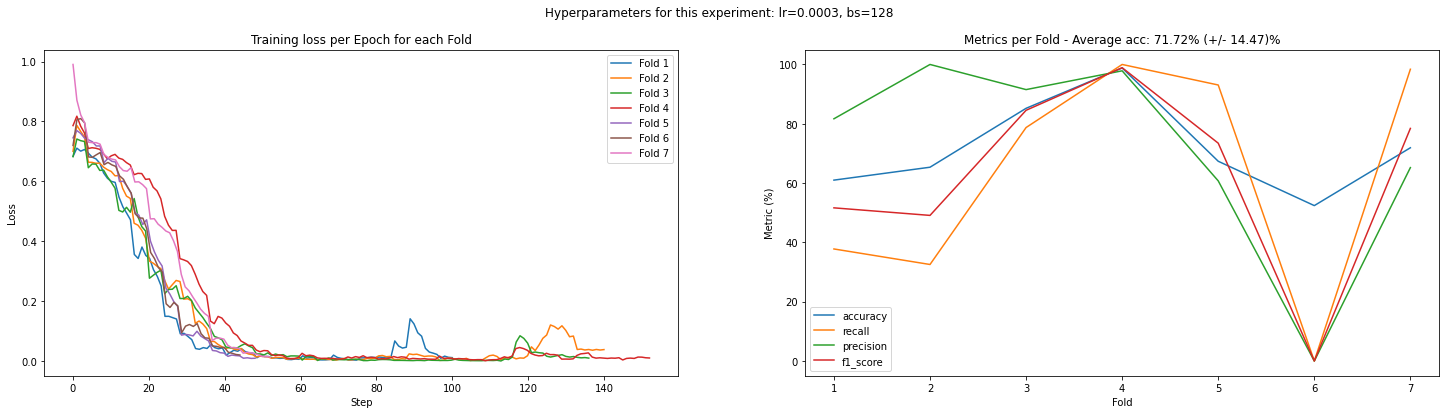

In [ ]:
# Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))

# Plot 1: Loss per epoch
n_epochs = [len(losses) for losses in losses_per_epoch] # Lista que tiene las épocas a las que llego cada fold * 3 prints para cada epoch
for n_epochs, fold_losses in zip(n_epochs, losses_per_epoch):
    ax1.plot(np.linspace(0, n_epochs, n_epochs), fold_losses, label=f'Fold {losses_per_epoch.index(fold_losses) + 1}')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training loss per Epoch for each Fold')
ax1.legend()

# Plot 2: Metrics per fold
for metric, values in results.items():
    if metric == 'accuracy':
        mean, std = np.mean(values), np.std(values)
    ax2.plot(range(1, groupk_folds + 1), values, label=f'{metric}')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Metric (%)')
ax2.set_title(f'Metrics per Fold - Average acc: {mean:.2f}% (+/- {std:.2f})%')
ax2.legend()

# Título principal
fig.suptitle(f'Hyperparameters for this experiment: lr={LEARNING_RATE}, bs={BATCH_SIZE}')
plt.show()

# <font color='#4C5FDA'> **5. Non-supervised 👁️**</color> <a name="tema8">

In [ ]:
algorithms = [
    ('kmeans', KMeans(n_clusters=2, n_init='auto')),
    ('ACWard', AgglomerativeClustering(n_clusters=2, linkage="ward")),
    ('ACAverage', AgglomerativeClustering(n_clusters=2, linkage="average")),
    ('ACSingle', AgglomerativeClustering(n_clusters=2, linkage="single")),
]

In [ ]:
def calculate_metrics(y_true, y_pred):

    accuracy = accuracy_score(y_true, y_pred)*100
    f1 = f1_score(y_true, y_pred)*100
    precision = precision_score(y_true, y_pred)*100
    recall = recall_score(y_true, y_pred)*100

    return f'accuracy {accuracy:.2f} f1 {f1:.2f}\n precision {precision:.2f} recall {recall:.2f}'

### <font color='#52F17F'> **Demostración Individual con audio**</color> <a name="tema9">

In [ ]:
kmeans = KMeans(n_clusters=2, n_init='auto')

In [ ]:
X = np.vstack(data['flatten_log_mel_spectogram'])
y = data['label'].values

In [ ]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [ ]:
y_pred = kmeans.fit_predict(X) # Same as training with X

In [ ]:
metrics = calculate_metrics(y_pred=y_pred, y_true=y)
print(metrics)

accuracy 43.35 f1 53.18
 precision 45.29 recall 64.40


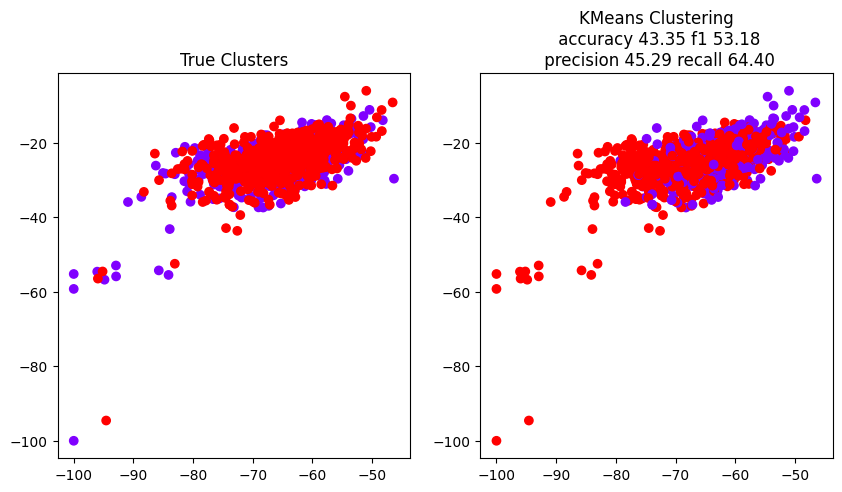

In [ ]:
plt.figure(figsize=(10, 5))

# Dibujar los verdaderos clusters
plt.subplot(1, 2, 1)  # Ajustar para incluir la gráfica de clusters verdaderos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
plt.title('True Clusters')
# Crear una subtrama para el resultado del clustering actual
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='rainbow')
plt.title(f'KMeans Clustering\n {metrics}')
plt.show()

## <font color='#EB9A54'> **5.1 Solo Audio Features**</color> <a name="tema8">

### <font color='#52F17F'> **5.1.2 Metricas para los diferentes Algoritmos de Clustering**</color> <a name="tema8">

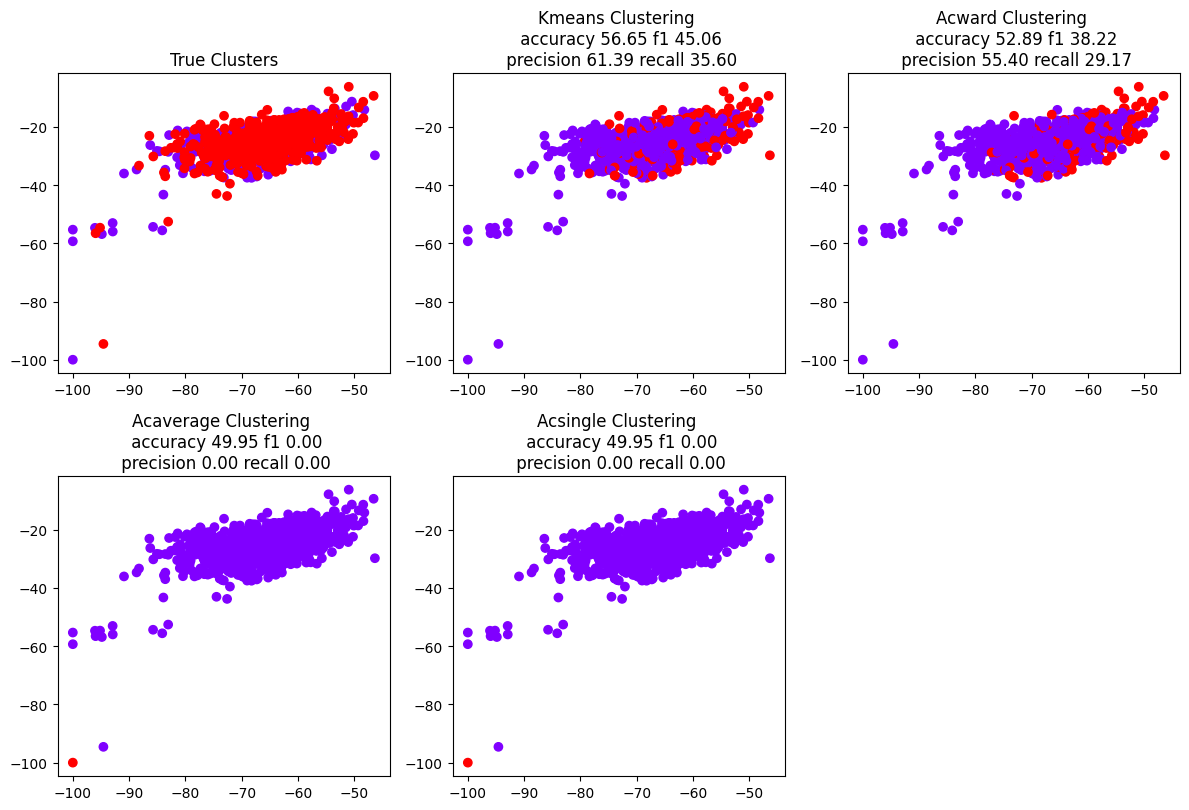

In [ ]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Incrementar la altura para acomodar 3 filas

num_algorithms = len(algorithms)
num_columns = (num_algorithms + 1 + 2) // 2  # Calcular el número de columnas necesarias

# Dibujar los verdaderos clusters
plt.subplot(3, num_columns, 1)  # Ajustar para incluir la gráfica de clusters verdaderos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
plt.title('True Clusters')

# Iterar sobre cada algoritmo y aplicar el clustering
for i, (name, alg) in enumerate(algorithms):
    # Aplicar el algoritmo de clustering
    clusters = alg.fit_predict(X)

    # Calcular métricas
    metrics = calculate_metrics(y, clusters)

    plt.subplot(3, num_columns, i + 2)
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='rainbow')

    # Título con el nombre del algoritmo y las métricas calculadas
    plt.title(f'{name.capitalize()} Clustering \n {metrics}')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()
plt.show()


## <font color='#EB9A54'> **5.2 Solo Video Features**</color> <a name="tema8">

### <font color='#52F17F'> **5.2.1 Prueba Individual**</color> <a name="tema8">

In [ ]:
kmeans = KMeans(n_clusters=2, n_init='auto')

In [ ]:
X = np.array(data['flatten_frame_sequence'].tolist())
y = data['label'].values

In [ ]:
kmeans.fit(X)

KMeans(n_clusters=2, n_init='auto')

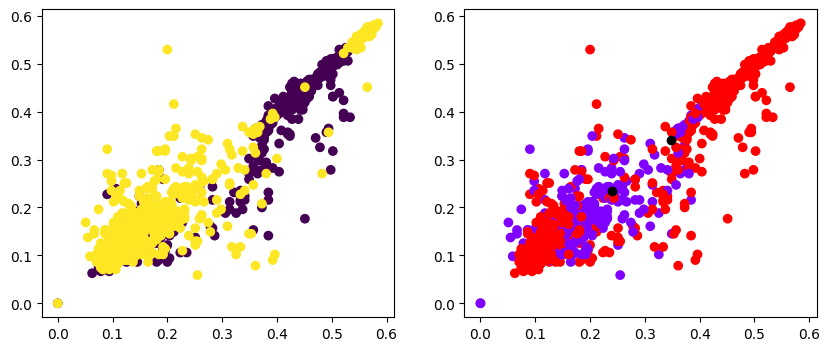

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=y)
plt.subplot(122)
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')

In [ ]:
clusters = kmeans.fit_predict(X)
print(np.array(clusters).shape)

(1091,)


### <font color='#52F17F'> **3.2.2 Metricas para los diferentes Algoritmos de Clustering**</color> <a name="tema8">

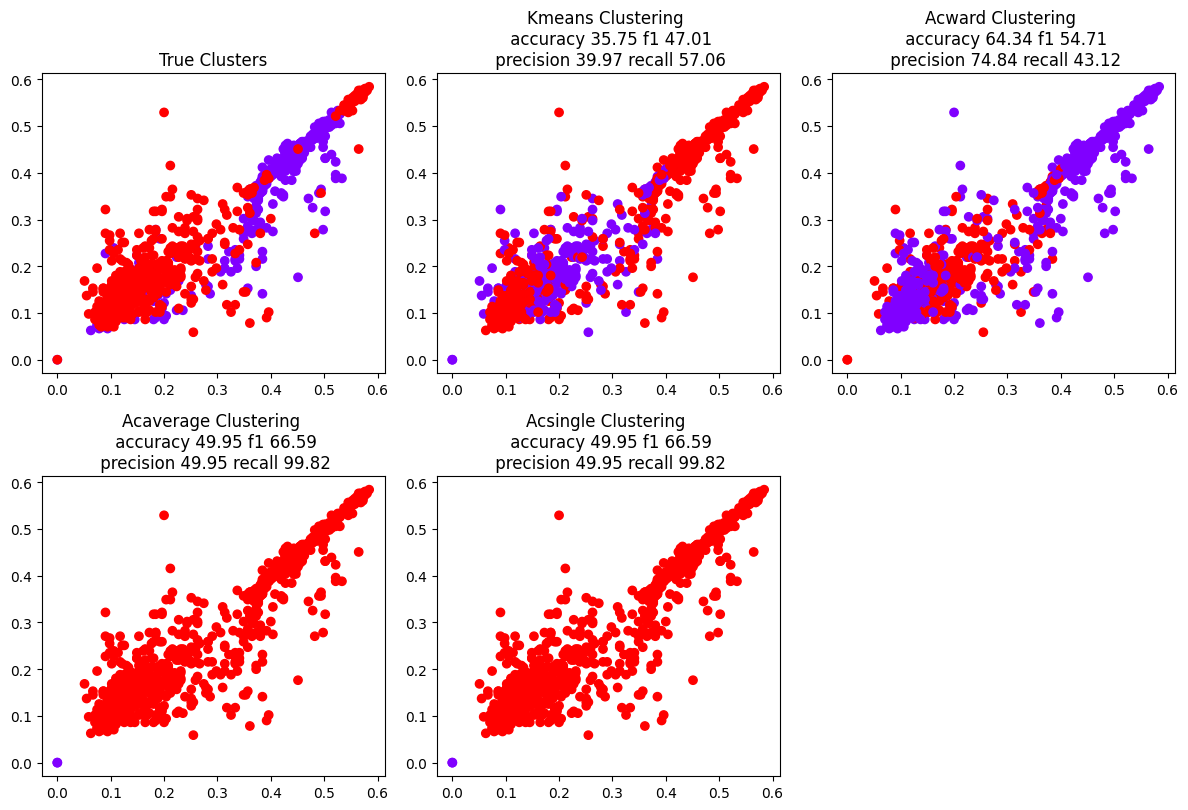

In [ ]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Incrementar la altura para acomodar 3 filas

num_algorithms = len(algorithms)
num_columns = (num_algorithms + 1 + 2) // 2  # Calcular el número de columnas necesarias

# Dibujar los verdaderos clusters
plt.subplot(3, num_columns, 1)  # Ajustar para incluir la gráfica de clusters verdaderos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
plt.title('True Clusters')

# Iterar sobre cada algoritmo y aplicar el clustering
for i, (name, alg) in enumerate(algorithms):
    # Aplicar el algoritmo de clustering
    clusters = alg.fit_predict(X)

    # Calcular métricas
    metrics = calculate_metrics(y, clusters)

    plt.subplot(3, num_columns, i + 2)
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='rainbow')

    # Título con el nombre del algoritmo y las métricas calculadas
    plt.title(f'{name.capitalize()} Clustering \n {metrics}')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()
plt.show()


## <font color='#EB9A54'> **5.3 Fusion of features**</color> <a name="tema8">

### <font color='#52F17F'> **5.3.1 Prueba Individual**</color> <a name="tema8">

In [ ]:
kmeans = KMeans(n_clusters=2, n_init='auto')

In [ ]:
X = np.array(data['fused_flattened_features'].tolist())
y = data['label'].values

In [ ]:
kmeans.fit(X)

KMeans(n_clusters=2, n_init='auto')

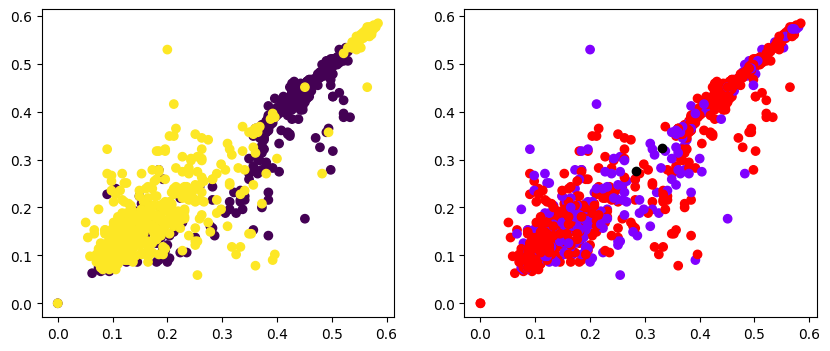

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=y)
plt.subplot(122)
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')

### <font color='#52F17F'> **3.3.2 Metricas para los diferentes Algoritmos de Clustering**</color> <a name="tema8">

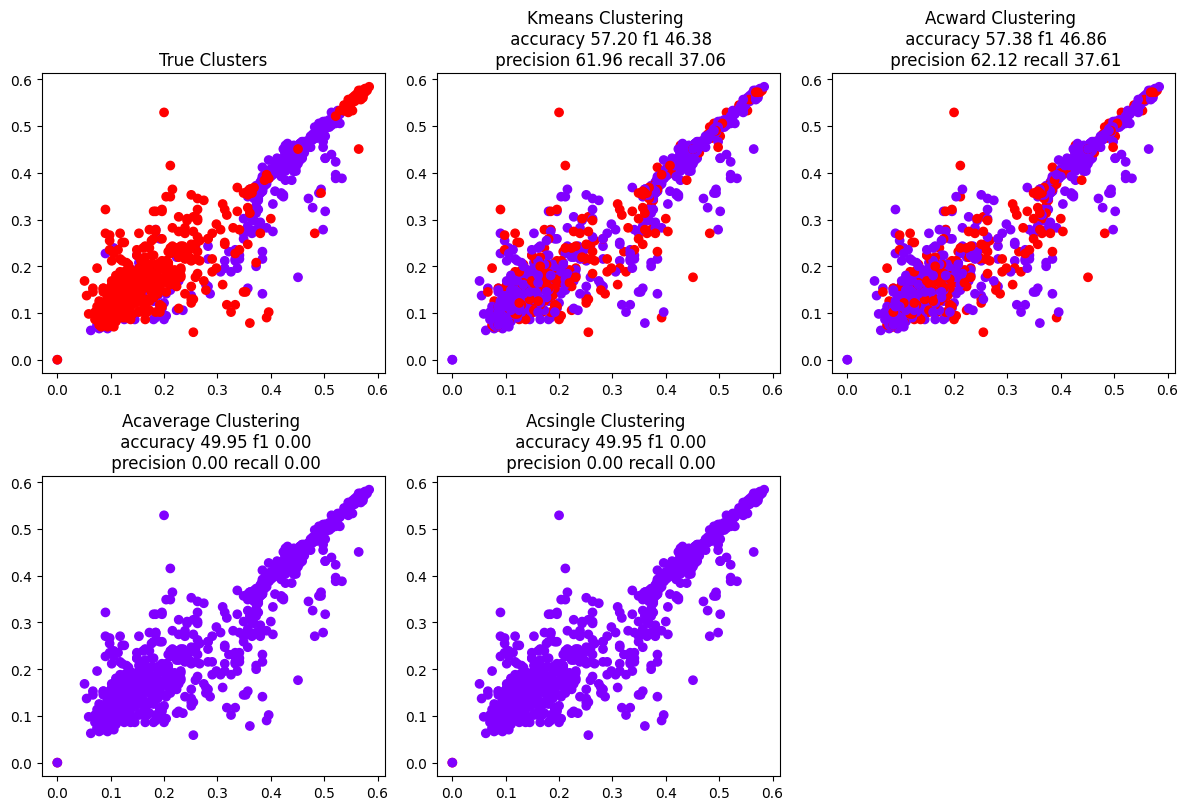

In [ ]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Incrementar la altura para acomodar 3 filas

num_algorithms = len(algorithms)
num_columns = (num_algorithms + 1 + 2) // 2  # Calcular el número de columnas necesarias

# Dibujar los verdaderos clusters
plt.subplot(3, num_columns, 1)  # Ajustar para incluir la gráfica de clusters verdaderos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
plt.title('True Clusters')

# Iterar sobre cada algoritmo y aplicar el clustering
for i, (name, alg) in enumerate(algorithms):
    # Aplicar el algoritmo de clustering
    clusters = alg.fit_predict(X)

    # Calcular métricas
    metrics = calculate_metrics(y, clusters)

    plt.subplot(3, num_columns, i + 2)
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='rainbow')

    # Título con el nombre del algoritmo y las métricas calculadas
    plt.title(f'{name.capitalize()} Clustering \n {metrics}')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()
plt.show()

# <font color='#4C5FDA'>**6. PCA Analysis**</font>

## <font color='#EB9A54'>**Hipomimia**</font>

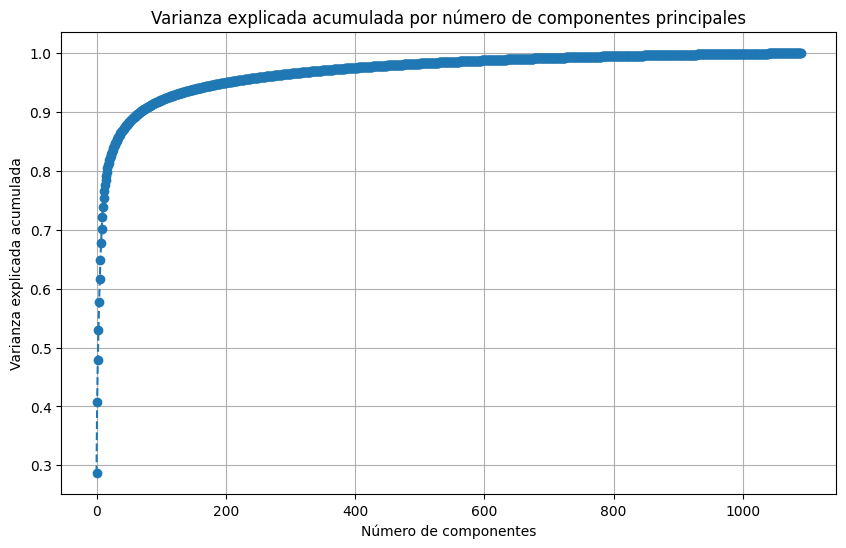

Número de componentes para retener el 90% de la varianza: 69
Número de componentes para retener el 95% de la varianza: 200
Número de componentes para retener el 99% de la varianza: 652


In [ ]:
pca_video = PCA()
pca_video.fit(np.vstack(data['flatten_frame_sequence']))

# Varianza explicada acumulada
explained_variance_ratio = np.cumsum(pca_video.explained_variance_ratio_)

# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada por número de componentes principales')
plt.grid(True)
plt.show()

# Imprimir el número de componentes para diferentes niveles de varianza explicada
thresholds = [0.90, 0.95, 0.99]
for threshold in thresholds:
    num_components = np.argmax(explained_variance_ratio >= threshold) + 1
    print(f'Número de componentes para retener el {int(threshold*100)}% de la varianza: {num_components}')

In [ ]:
pca = PCA(n_components=69)

converted = pca.fit_transform(np.vstack(data['flatten_frame_sequence']))
converted = [row for row in converted]
data['pca_flatten_frame_sequence'] = converted
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence,fused_flattened_features,pca_flatten_log_mel_spectogram,pca_flatten_frame_sequence
patient,,,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44...","[0.44313725490196076, 0.4470588235294118, 0.44...","[-146.87453743909916, 39.473674991413205, -11....","[-4.595280588132663, 24.683745586722914, 6.690..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458...","[0.4627450980392157, 0.4627450980392157, 0.458...","[-214.1628682984351, 109.95630385447593, -152....","[-3.864669403017602, 22.542839684109985, 7.230..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474...","[0.4666666666666667, 0.4666666666666667, 0.474...","[-271.45664355671556, 48.46460586681956, 26.37...","[-4.72019855782221, 23.37272236443247, 5.34050..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4...","[0.44313725490196076, 0.44313725490196076, 0.4...","[80.03360474596444, -30.185493257024223, -27.3...","[1.1824708722405526, 26.16580498762466, 9.0497..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45...","[0.4627450980392157, 0.45098039215686275, 0.45...","[-94.45165273379726, 92.81292282741705, 35.253...","[-2.6796593130353346, 24.029221663542, 6.85672..."


## <font color='#EB9A54'>**Disartria**</font>

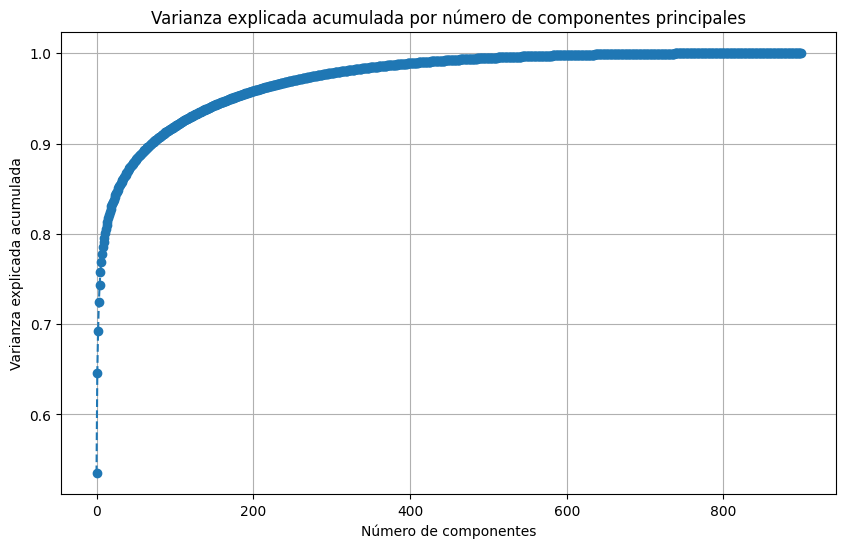

Número de componentes para retener el 90% de la varianza: 72
Número de componentes para retener el 95% de la varianza: 174
Número de componentes para retener el 99% de la varianza: 416


In [ ]:
pca_audio = PCA()
pca_audio.fit(np.vstack(data['flatten_log_mel_spectogram']))

# Varianza explicada acumulada
explained_variance_ratio = np.cumsum(pca_audio.explained_variance_ratio_)

# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada por número de componentes principales')
plt.grid(True)
plt.show()

# Imprimir el número de componentes para diferentes niveles de varianza explicada
thresholds = [0.90, 0.95, 0.99]
for threshold in thresholds:
    num_components = np.argmax(explained_variance_ratio >= threshold) + 1
    print(f'Número de componentes para retener el {int(threshold*100)}% de la varianza: {num_components}')

In [ ]:
pca = PCA(n_components=72)

converted = pca.fit_transform(np.vstack(data['flatten_log_mel_spectogram']))
converted = [row for row in converted]
data['pca_flatten_log_mel_spectogram'] = converted
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence,fused_flattened_features,pca_flatten_log_mel_spectogram
patient,,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44...","[0.44313725490196076, 0.4470588235294118, 0.44...","[-146.87453743909916, 39.473674991413205, -11...."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458...","[0.4627450980392157, 0.4627450980392157, 0.458...","[-214.1628682984351, 109.95630385447593, -152...."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474...","[0.4666666666666667, 0.4666666666666667, 0.474...","[-271.45664355671556, 48.46460586681956, 26.37..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4...","[0.44313725490196076, 0.44313725490196076, 0.4...","[80.03360474596444, -30.185493257024223, -27.3..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45...","[0.4627450980392157, 0.45098039215686275, 0.45...","[-94.45165273379726, 92.81292282741705, 35.253..."


## <font color='#EB9A54'>**Fusion of features**</font>

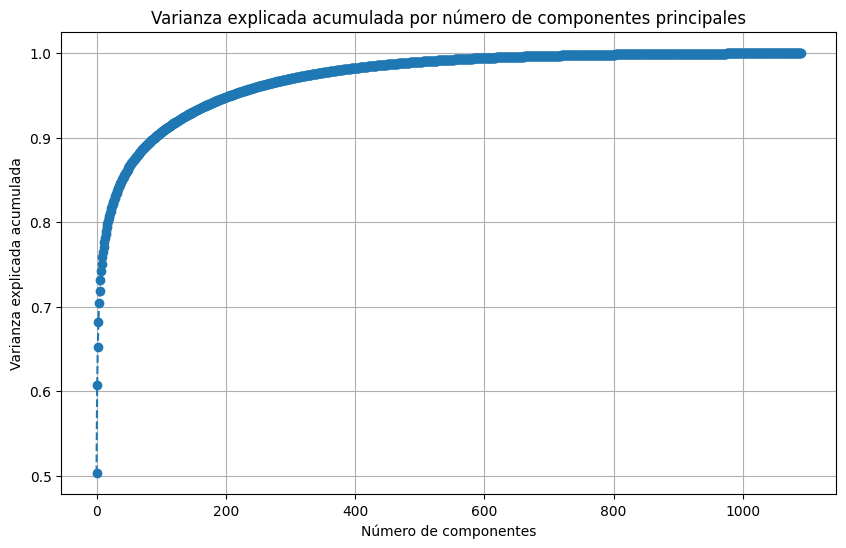

Número de componentes para retener el 90% de la varianza: 91
Número de componentes para retener el 95% de la varianza: 208
Número de componentes para retener el 99% de la varianza: 503


In [ ]:
pca_fused_feat = PCA()
pca_fused_feat.fit(np.vstack(data['fused_flattened_features']))

# Varianza explicada acumulada
explained_variance_ratio = np.cumsum(pca_fused_feat.explained_variance_ratio_)

# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada por número de componentes principales')
plt.grid(True)
plt.show()

# Imprimir el número de componentes para diferentes niveles de varianza explicada
thresholds = [0.90, 0.95, 0.99]
for threshold in thresholds:
    num_components = np.argmax(explained_variance_ratio >= threshold) + 1
    print(f'Número de componentes para retener el {int(threshold*100)}% de la varianza: {num_components}')

In [ ]:
pca = PCA(n_components=91)

converted = pca.fit_transform(np.vstack(data['fused_flattened_features']))
converted = [row for row in converted]
data['pca_fused_flattened_features'] = converted
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence,fused_flattened_features,pca_flatten_log_mel_spectogram,pca_flatten_frame_sequence,pca_fused_flattened_features
patient,,,,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44...","[0.44313725490196076, 0.4470588235294118, 0.44...","[-146.87453743909916, 39.473674991413205, -11....","[-4.595280588132663, 24.683745586722914, 6.690...","[-146.07385004409764, 39.71078323758914, -13.3..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458...","[0.4627450980392157, 0.4627450980392157, 0.458...","[-214.1628682984351, 109.95630385447593, -152....","[-3.864669403017602, 22.542839684109985, 7.230...","[-213.3287823772534, 110.5580374868841, -149.8..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474...","[0.4666666666666667, 0.4666666666666667, 0.474...","[-271.45664355671556, 48.46460586681956, 26.37...","[-4.72019855782221, 23.37272236443247, 5.34050...","[-270.53810520710374, 48.7851859269735, 23.169..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4...","[0.44313725490196076, 0.44313725490196076, 0.4...","[80.03360474596444, -30.185493257024223, -27.3...","[1.1824708722405526, 26.16580498762466, 9.0497...","[80.63109017357371, -29.97129119405373, -27.91..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45...","[0.4627450980392157, 0.45098039215686275, 0.45...","[-94.45165273379726, 92.81292282741705, 35.253...","[-2.6796593130353346, 24.029221663542, 6.85672...","[-93.74823690226754, 92.74274833807985, 33.705..."


# <font color='#4C5FDA'> **7. PCA + Machine Learning 🦾**</color> <a name="tema8">

## <font color='#EB9A54'>**7.1 Solo audio features**</font> <a name = "tema10">

In [ ]:
X = np.array(data['flatten_log_mel_spectogram'].tolist())
y = data['label'].values

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Inicializar un diccionario para almacenar las métricas de evaluación
results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'sensitivity': []} for name, _ in models}

# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=7)

groups = data.index.values

'''
Crear un PCA con componentes para el audio.
Este 72 sale de la ejecución de la celda anterior, donde se encuentra
que cantidad de componentes explica la mayor cantidad de varianza de
la imágen
'''
pca = PCA( n_components=72 )


'''
Dentro del for, hacer el fit_transform separado para train y para test,
sólo para el X
'''


# Realizar la validación cruzada por grupos
for (train_index, test_index) in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    X_train, X_test = pca.fit_transform(X_train), pca.fit_transform(X_test)

    # Entrenar y evaluar cada modelo
    for name, model in models:
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)

        results[name]['accuracy'].append(accuracy)
        results[name]['f1'].append(f1)
        results[name]['precision'].append(precision)
        results[name]['sensitivity'].append(sensitivity)

In [ ]:
# Show results
for name, metrics in results.items():
    print(f"{11*'='} Resultados para {name} {11*'='}")
    for metric, score in metrics.items():
        print(f"  {metric}: {np.mean(score)*100:.2f}% (+/- {np.std(score)*100:.2f}%)")
    print()

=========== Resultados para GNB ===========
  accuracy: 44.54% (+/- 7.79%)
  f1: 40.34% (+/- 9.29%)
  precision: 43.55% (+/- 8.61%)
  sensitivity: 38.15% (+/- 10.98%)

=========== Resultados para DT DEFAULT ===========
  accuracy: 50.13% (+/- 6.57%)
  f1: 49.90% (+/- 7.28%)
  precision: 50.02% (+/- 6.55%)
  sensitivity: 50.08% (+/- 9.03%)

=========== Resultados para DT2 ===========
  accuracy: 55.18% (+/- 8.79%)
  f1: 46.76% (+/- 17.87%)
  precision: 56.03% (+/- 12.73%)
  sensitivity: 45.94% (+/- 27.30%)

=========== Resultados para DT40 ===========
  accuracy: 50.68% (+/- 7.61%)
  f1: 49.82% (+/- 9.24%)
  precision: 50.40% (+/- 8.20%)
  sensitivity: 49.70% (+/- 11.37%)

=========== Resultados para RF50 ===========
  accuracy: 49.58% (+/- 5.20%)
  f1: 48.62% (+/- 7.38%)
  precision: 49.36% (+/- 5.68%)
  sensitivity: 48.60% (+/- 10.77%)

=========== Resultados para RF100 ===========
  accuracy: 48.76% (+/- 4.20%)
  f1: 48.56% (+/- 9.29%)
  precision: 48.11% (+/- 4.79%)
  sensitivity: 5

## <font color='#EB9A54'>**7.2 Solo video features**</font> <a name = "tema9">

In [ ]:
X = np.array(data['flatten_frame_sequence'].tolist())
y = data['label'].values

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Inicializar un diccionario para almacenar las métricas de evaluación
results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'sensitivity': []} for name, _ in models}

# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=7)

groups = data.index.values

pca = PCA( n_components=69 )

# Realizar la validación cruzada por grupos
for (train_index, test_index) in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    X_train, X_test = pca.fit_transform(X_train), pca.fit_transform(X_test)

    # Entrenar y evaluar cada modelo
    for name, model in models:
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)

        results[name]['accuracy'].append(accuracy)
        results[name]['f1'].append(f1)
        results[name]['precision'].append(precision)
        results[name]['sensitivity'].append(sensitivity)

In [ ]:
# Show results
for name, metrics in results.items():
    print(f"{11*'='} Resultados para {name} {11*'='}")
    for metric, score in metrics.items():
        print(f"  {metric}: {np.mean(score)*100:.2f}% (+/- {np.std(score)*100:.2f}%)")
    print()

=========== Resultados para GNB ===========
  accuracy: 59.77% (+/- 13.65%)
  f1: 45.97% (+/- 24.89%)
  precision: 60.75% (+/- 25.59%)
  sensitivity: 39.13% (+/- 24.10%)

=========== Resultados para DT DEFAULT ===========
  accuracy: 55.27% (+/- 15.44%)
  f1: 50.66% (+/- 21.77%)
  precision: 54.31% (+/- 23.98%)
  sensitivity: 48.82% (+/- 21.35%)

=========== Resultados para DT2 ===========
  accuracy: 56.92% (+/- 15.00%)
  f1: 50.12% (+/- 23.04%)
  precision: 55.96% (+/- 19.47%)
  sensitivity: 48.99% (+/- 24.70%)

=========== Resultados para DT40 ===========
  accuracy: 55.00% (+/- 15.53%)
  f1: 50.54% (+/- 21.75%)
  precision: 54.04% (+/- 23.99%)
  sensitivity: 48.82% (+/- 21.35%)

=========== Resultados para RF50 ===========
  accuracy: 46.29% (+/- 13.60%)
  f1: 40.64% (+/- 15.69%)
  precision: 47.44% (+/- 21.82%)
  sensitivity: 38.01% (+/- 15.97%)

=========== Resultados para RF100 ===========
  accuracy: 46.75% (+/- 13.61%)
  f1: 39.47% (+/- 15.00%)
  precision: 47.87% (+/- 22.27%)

## <font color='#EB9A54'>**7.3 Fusion of features**</font> <a name = "tema9">

In [ ]:
X = np.array(data['fused_flattened_features'].tolist())
y = data['label'].values

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Inicializar un diccionario para almacenar las métricas de evaluación
results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'sensitivity': []} for name, _ in models}

# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=7)

groups = data.index.values

pca = PCA(n_components=91)

# Realizar la validación cruzada por grupos
for (train_index, test_index) in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train, X_test = pca.fit_transform(X_train), pca.fit_transform(X_test)

    # Entrenar y evaluar cada modelo
    for name, model in models:
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)

        results[name]['accuracy'].append(accuracy)
        results[name]['f1'].append(f1)
        results[name]['precision'].append(precision)
        results[name]['sensitivity'].append(sensitivity)

In [ ]:
# Show results
for name, metrics in results.items():
    print(f"{11*'='} Resultados para {name} {11*'='}")
    for metric, score in metrics.items():
        print(f"  {metric}: {np.mean(score)*100:.2f}% (+/- {np.std(score)*100:.2f}%)")
    print()

=========== Resultados para GNB ===========
  accuracy: 63.90% (+/- 16.74%)
  f1: 49.64% (+/- 30.56%)
  precision: 63.18% (+/- 26.85%)
  sensitivity: 45.58% (+/- 33.02%)

=========== Resultados para DT DEFAULT ===========
  accuracy: 54.82% (+/- 15.86%)
  f1: 49.98% (+/- 21.52%)
  precision: 54.42% (+/- 24.25%)
  sensitivity: 47.53% (+/- 20.83%)

=========== Resultados para DT2 ===========
  accuracy: 57.19% (+/- 14.80%)
  f1: 50.32% (+/- 23.00%)
  precision: 56.51% (+/- 18.83%)
  sensitivity: 49.17% (+/- 24.67%)

=========== Resultados para DT40 ===========
  accuracy: 55.00% (+/- 15.88%)
  f1: 50.18% (+/- 21.59%)
  precision: 54.55% (+/- 24.31%)
  sensitivity: 47.72% (+/- 20.71%)

=========== Resultados para RF50 ===========
  accuracy: 47.67% (+/- 14.15%)
  f1: 43.79% (+/- 16.09%)
  precision: 48.13% (+/- 19.41%)
  sensitivity: 41.31% (+/- 15.57%)

=========== Resultados para RF100 ===========
  accuracy: 48.86% (+/- 13.40%)
  f1: 42.34% (+/- 16.91%)
  precision: 48.91% (+/- 20.72%)

# <font color='#4C5FDA'>**8. PCA + Deep Learning 🤖**</font>

## <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

In [ ]:
class PatientDataset(Dataset):
  def __init__(self, dataframe, n_frames = FRAMES_PROMEDIO):
    self.dataframe = dataframe
    self.n_frames = n_frames

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Leemos el audio
    audio = self.dataframe['pca_flatten_log_mel_spectogram'][index].astype(np.float32)
    audio = torch.from_numpy(audio)

    """ Carga de los frames """

    # video_path = os.path.join(self.dataframe['frames_path'][index])
    frames = self.dataframe['pca_flatten_frame_sequence'][index].astype(np.float32)
    frames = torch.from_numpy(frames)

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'Parkinson' 1
    # sino 0.

    label = 1 if 'Parkinson' in self.dataframe['audio_path'][index] else 0

    return audio, frames, label


## <font color='#52F17F'>**Partición de los datos**</font>

In [ ]:
def make_folds(data:pd.DataFrame):
    # Extraer los datos para GroupKFold
    X = np.array([i for i in range(len(data))])
    y = data['label'].values
    groups = data.index.values

    folds_dict = {}
    groupk_folds = 7
    gkf = GroupKFold(n_splits=groupk_folds)

    # Realizar la validación cruzada por grupos
    for i, (train_index, test_index) in enumerate(gkf.split(X, y, groups), 1):
        fold_name = f"fold_{i}"
        folds_dict[fold_name] = {
            'train': train_index,
            'test': test_index
        }

    return folds_dict

def make_subdataframes(data:pd.DataFrame, folds:dict):
  # Crear subdataframes
  subdataframes = {}

  for fold_name, indices in folds.items():
      train_df = data.iloc[indices['train']]
      test_df = data.iloc[indices['test']]

      subdataframes[fold_name] = {
          'train': train_df,
          'test': test_df
      }

  return subdataframes

In [ ]:
def get_data(slice:int=1, fold:int=None):

    # Generate folds
    folds = make_folds(data)

    # Create subdataframes
    subdataframes = make_subdataframes(data, folds)

    if not fold:
      fold = np.random.choice(range(1, 8))

    fold_name = f'fold_{fold}'

    train_dataframe = apply_pca(subdataframes[fold_name]['train'])
    test_dataframe = apply_pca(subdataframes[fold_name]['test'])

    print(f"FOLD {fold}\n-------------------------------")

    train_dataset = PatientDataset(train_dataframe)
    test_dataset = PatientDataset(test_dataframe)

    # test with less data, it helped me to set up the experiments faster if slice=1
    # then it returns the complete dataset
    train_dataset = torch.utils.data.Subset(train_dataset,
                                            indices=range(0, len(train_dataset), slice))
    test_dataset = torch.utils.data.Subset(test_dataset,
                                            indices=range(0, len(test_dataset), slice))

    return train_dataset, test_dataset

def make_loader(dataset, batch_size):
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                        pin_memory=True, num_workers=2)
    return loader

In [ ]:
train, test = get_data()
print(train.__len__(), test.__len__())
print(train[0][0].shape, train[0][1].shape , train[0][2])

FOLD 6
-------------------------------
935 156
torch.Size([72]) torch.Size([69]) 0


## <font color='#52F17F'>**Multimodal fully connected model**</font>

In [ ]:
class MiddleModule(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.fc = nn.Linear(in_features, out_features)
    self.relu = nn.ReLU(inplace=True)
    self.dropout = nn.Dropout(inplace=True)

  def forward(self, x):
    x = self.fc(x)
    x = self.relu(x)
    return x

class MultimodalModel(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.fc1 = nn.Linear((69+72), 512)
    self.features_module = nn.Sequential(
      MiddleModule(512, 256),
      MiddleModule(256, 128),
      MiddleModule(128, 64),
    )
    self.fc4 = nn.Linear(64, n_classes)


  def forward(self, audio, video):

    combined = torch.cat((video, audio), dim=1) # https://pytorch.org/docs/stable/generated/torch.cat.html
    x = F.relu(self.fc1(combined))
    x = self.features_module(x)
    x = self.fc4(x)
    return x

In [ ]:
# Test al modelo, para ver si nos entrega la salida esperada

input_audio = torch.rand([2, 72])
input_video = torch.rand([2, 69])
print(f"Entrada audio: {input_audio.size(), input_audio.dtype}")
print(f"Entrada video: {input_video.size(), input_video.dtype}")

model = MultimodalModel(n_classes=1)
ouput = model(input_audio, input_video)
print(f"Salida: {ouput.size()}")

Entrada audio: (torch.Size([2, 72]), torch.float32)
Entrada video: (torch.Size([2, 69]), torch.float32)
Salida: torch.Size([2, 1])


In [ ]:
print(model)

MultimodalModel(
  (fc1): Linear(in_features=141, out_features=512, bias=True)
  (features_module): Sequential(
    (0): MiddleModule(
      (fc): Linear(in_features=512, out_features=256, bias=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.5, inplace=True)
    )
    (1): MiddleModule(
      (fc): Linear(in_features=256, out_features=128, bias=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.5, inplace=True)
    )
    (2): MiddleModule(
      (fc): Linear(in_features=128, out_features=64, bias=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.5, inplace=True)
    )
  )
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
summary(model, (input_video.size(), input_audio.size()))

Layer (type:depth-idx)                   Output Shape              Param #
MultimodalModel                          [2, 1]                    --
├─Linear: 1-1                            [2, 512]                  72,704
├─Sequential: 1-2                        [2, 64]                   --
│    └─MiddleModule: 2-1                 [2, 256]                  --
│    │    └─Linear: 3-1                  [2, 256]                  131,328
│    │    └─ReLU: 3-2                    [2, 256]                  --
│    └─MiddleModule: 2-2                 [2, 128]                  --
│    │    └─Linear: 3-3                  [2, 128]                  32,896
│    │    └─ReLU: 3-4                    [2, 128]                  --
│    └─MiddleModule: 2-3                 [2, 64]                   --
│    │    └─Linear: 3-5                  [2, 64]                   8,256
│    │    └─ReLU: 3-6                    [2, 64]                   --
├─Linear: 1-3                            [2, 1]                    65

## <font color='#52F17F'>**Utils functions and hyperparameters**</font>

In [ ]:
# Hiperparametros
LEARNING_RATE = 0.00006
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128

## <font color='#52F17F'>**Fusion of features**</font>

In [ ]:
# Acá vamos a guardar las métricas del modelo
results = {
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1_score": []
}

# Storage losses for plotting
losses_per_epoch = []

# Loop encontrado y modificado de: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
for fold in range(1, 8):
  # Storage for current fold
  losses = []

  # make the model, data, loss, metrics and optimization problem
  model, train_loader, test_loader, criterion, optimizer, accuracy_fn, f1_score_fn, recall_fn, precision_fn, epochs = make(fold=fold)

  # and use them to train the model
  test_accuracy, test_f1, test_recall, test_precision = train(model, train_loader, test_loader, criterion, optimizer, accuracy_fn, f1_score_fn, recall_fn, precision_fn, epochs, losses)

  # Store losses for current fold
  losses_per_epoch.append(losses)

  results["accuracy"].append(test_accuracy.cpu() * 100)
  results["recall"].append(test_recall.cpu() * 100)
  results["precision"].append(test_precision.cpu() * 100)
  results["f1_score"].append(test_f1.cpu() * 100)

FOLD 1
-------------------------------
Epoch 1
-------------------------------
train loss: 0.720 accuracy: 0.480 [after 2 batches]
train loss: 0.703 accuracy: 0.537 [after 4 batches]
train loss: 0.696 accuracy: 0.574 [after 6 batches]
train loss: 0.687 accuracy: 0.630 [after 8 batches]
test loss: 0.711 accuracy: 0.366 recall: 0.275 precision: 0.348 f1: 0.307 [after 2 batches]
Epoch 2
-------------------------------
train loss: 0.662 accuracy: 0.750 [after 2 batches]
train loss: 0.655 accuracy: 0.777 [after 4 batches]
train loss: 0.651 accuracy: 0.770 [after 6 batches]
train loss: 0.644 accuracy: 0.771 [after 8 batches]
test loss: 0.732 accuracy: 0.360 recall: 0.200 precision: 0.276 f1: 0.231 [after 2 batches]
Epoch 3
-------------------------------
train loss: 0.621 accuracy: 0.836 [after 2 batches]
train loss: 0.619 accuracy: 0.826 [after 4 batches]
train loss: 0.616 accuracy: 0.831 [after 6 batches]
train loss: 0.614 accuracy: 0.824 [after 8 batches]
test loss: 0.749 accuracy: 0.307 

In [ ]:
# Print fold results
print(f'GROUP K-FOLD CROSS VALIDATION RESULTS FOR {groupk_folds} FOLDS')
print('--------------------------------')
for metric, values in results.items():
    print(f'{metric}:')
    for fold_idx, value in enumerate(values, 1):
        print(f'  fold {fold_idx}: {value:.2f}')
    print(f'  average: {np.mean(values):.2f}% (+/- {np.std(values):.2f}%)')

GROUP K-FOLD CROSS VALIDATION RESULTS FOR 7 FOLDS
--------------------------------
accuracy:
  fold 1: 35.27
  fold 2: 81.47
  fold 3: 82.31
  fold 4: 20.42
  fold 5: 39.62
  fold 6: 25.39
  fold 7: 96.98
  average: 54.49% (+/- 29.04%)
recall:
  fold 1: 25.40
  fold 2: 70.62
  fold 3: 87.05
  fold 4: 23.08
  fold 5: 40.79
  fold 6: 37.14
  fold 7: 96.15
  average: 54.32% (+/- 27.72%)
precision:
  fold 1: 32.54
  fold 2: 84.50
  fold 3: 79.43
  fold 4: 19.67
  fold 5: 41.42
  fold 6: 23.93
  fold 7: 97.76
  average: 54.18% (+/- 29.75%)
f1_score:
  fold 1: 28.52
  fold 2: 76.94
  fold 3: 83.03
  fold 4: 21.21
  fold 5: 41.06
  fold 6: 26.97
  fold 7: 96.85
  average: 53.51% (+/- 28.85%)


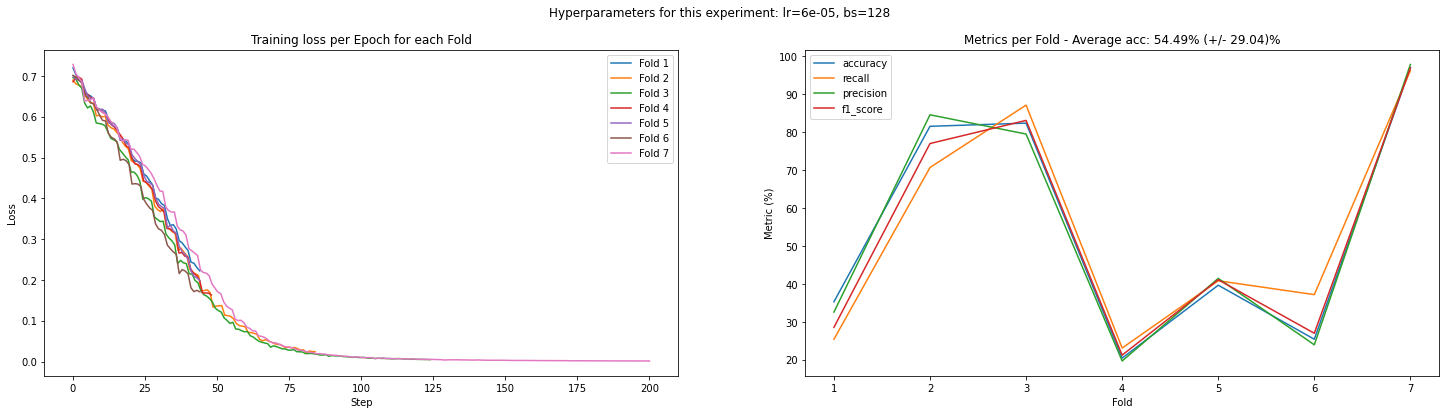

In [ ]:
# Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))

# Plot 1: Loss per epoch
n_epochs = [len(losses) for losses in losses_per_epoch] # Lista que tiene las épocas a las que llego cada fold * 3 prints para cada epoch
for n_epochs, fold_losses in zip(n_epochs, losses_per_epoch):
    ax1.plot(np.linspace(0, n_epochs, n_epochs), fold_losses, label=f'Fold {losses_per_epoch.index(fold_losses) + 1}')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training loss per Epoch for each Fold')
ax1.legend()

# Plot 2: Metrics per fold
for metric, values in results.items():
    if metric == 'accuracy':
        mean, std = np.mean(values), np.std(values)
    ax2.plot(range(1, groupk_folds + 1), values, label=f'{metric}')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Metric (%)')
ax2.set_title(f'Metrics per Fold - Average acc: {mean:.2f}% (+/- {std:.2f})%')
ax2.legend()

# Título principal
fig.suptitle(f'Hyperparameters for this experiment: lr={LEARNING_RATE}, bs={BATCH_SIZE}')
plt.show()

# <font color='#4C5FDA'> **9. PCA + Non-supervised 👁️**</color> <a name="tema8">

### <font color='#52F17F'> **Demostración Individual con audio**</color> <a name="tema9">

In [ ]:
kmeans = KMeans(n_clusters=2, n_init='auto')

In [ ]:
X = np.vstack(data['pca_flatten_log_mel_spectogram'])
y = data['label'].values

In [ ]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [ ]:
y_pred = kmeans.fit_predict(X) # Same as training with X

In [ ]:
metrics = calculate_metrics(y_pred=y_pred, y_true=y)
print(metrics)

accuracy 56.65 f1 45.19
 precision 61.32 recall 35.78


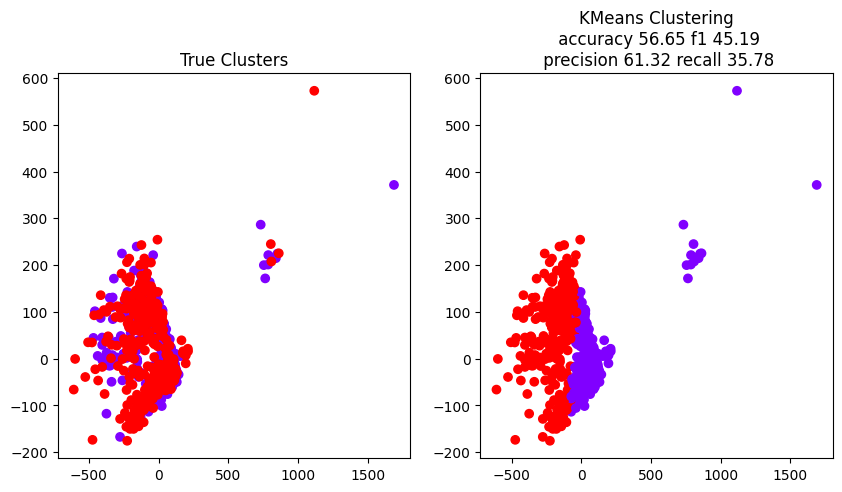

In [ ]:
plt.figure(figsize=(10, 5))

# Dibujar los verdaderos clusters
plt.subplot(1, 2, 1)  # Ajustar para incluir la gráfica de clusters verdaderos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
plt.title('True Clusters')
# Crear una subtrama para el resultado del clustering actual
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='rainbow')
plt.title(f'KMeans Clustering\n {metrics}')
plt.show()

## <font color='#EB9A54'> **9.1 Solo Audio Features**</color> <a name="tema8">

### <font color='#52F17F'> **9.1.2 Metricas para los diferentes Algoritmos de Clustering**</color> <a name="tema8">

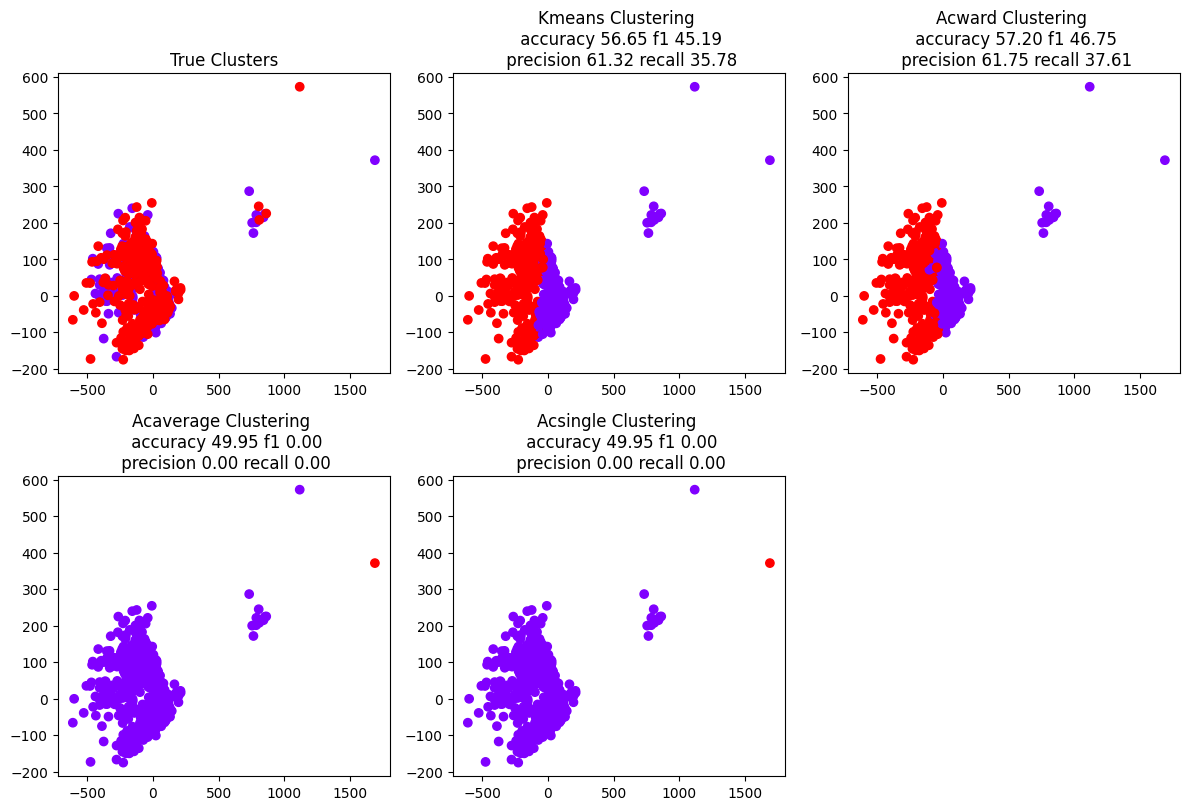

In [ ]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Incrementar la altura para acomodar 3 filas

num_algorithms = len(algorithms)
num_columns = (num_algorithms + 1 + 2) // 2  # Calcular el número de columnas necesarias

# Dibujar los verdaderos clusters
plt.subplot(3, num_columns, 1)  # Ajustar para incluir la gráfica de clusters verdaderos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
plt.title('True Clusters')

# Iterar sobre cada algoritmo y aplicar el clustering
for i, (name, alg) in enumerate(algorithms):
    # Aplicar el algoritmo de clustering
    clusters = alg.fit_predict(X)

    # Calcular métricas
    metrics = calculate_metrics(y, clusters)

    plt.subplot(3, num_columns, i + 2)
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='rainbow')

    # Título con el nombre del algoritmo y las métricas calculadas
    plt.title(f'{name.capitalize()} Clustering \n {metrics}')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()
plt.show()


## <font color='#EB9A54'> **9.2 Solo Video Features**</color> <a name="tema8">

### <font color='#52F17F'> **9.2.1 Prueba Individual**</color> <a name="tema8">

In [ ]:
kmeans = KMeans(n_clusters=2, n_init='auto')

In [ ]:
X = np.array(data['pca_flatten_frame_sequence'].tolist())
y = data['label'].values

In [ ]:
kmeans.fit(X)

KMeans(n_clusters=2, n_init='auto')

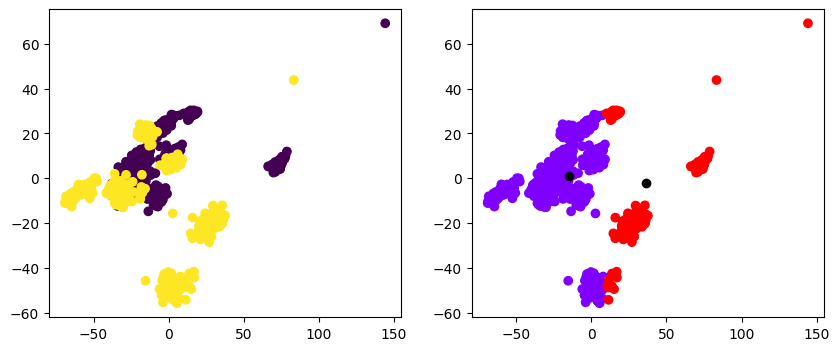

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=y)
plt.subplot(122)
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')

In [ ]:
clusters = kmeans.fit_predict(X)
print(np.array(clusters).shape)

(1091,)


### <font color='#52F17F'> **9.2.2 Metricas para los diferentes Algoritmos de Clustering**</color> <a name="tema8">

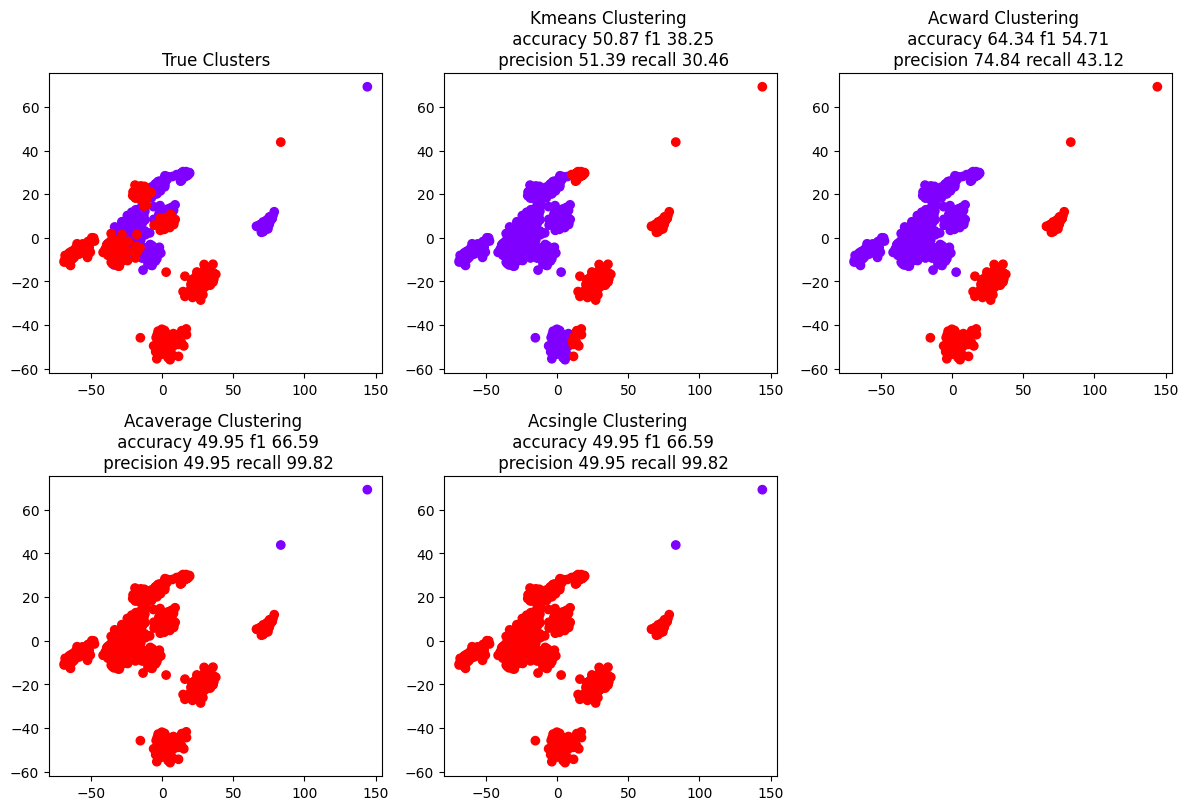

In [ ]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Incrementar la altura para acomodar 3 filas

num_algorithms = len(algorithms)
num_columns = (num_algorithms + 1 + 2) // 2  # Calcular el número de columnas necesarias

# Dibujar los verdaderos clusters
plt.subplot(3, num_columns, 1)  # Ajustar para incluir la gráfica de clusters verdaderos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
plt.title('True Clusters')

# Iterar sobre cada algoritmo y aplicar el clustering
for i, (name, alg) in enumerate(algorithms):
    # Aplicar el algoritmo de clustering
    clusters = alg.fit_predict(X)

    # Calcular métricas
    metrics = calculate_metrics(y, clusters)

    plt.subplot(3, num_columns, i + 2)
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='rainbow')

    # Título con el nombre del algoritmo y las métricas calculadas
    plt.title(f'{name.capitalize()} Clustering \n {metrics}')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()
plt.show()


## <font color='#EB9A54'> **9.3 Fusion of features**</color> <a name="tema8">

### <font color='#52F17F'> **9.3.1 Prueba Individual**</color> <a name="tema8">

In [ ]:
kmeans = KMeans(n_clusters=2, n_init='auto')

In [ ]:
X = np.array(data['pca_fused_flattened_features'].tolist())
y = data['label'].values

In [ ]:
kmeans.fit(X)

KMeans(n_clusters=2, n_init='auto')

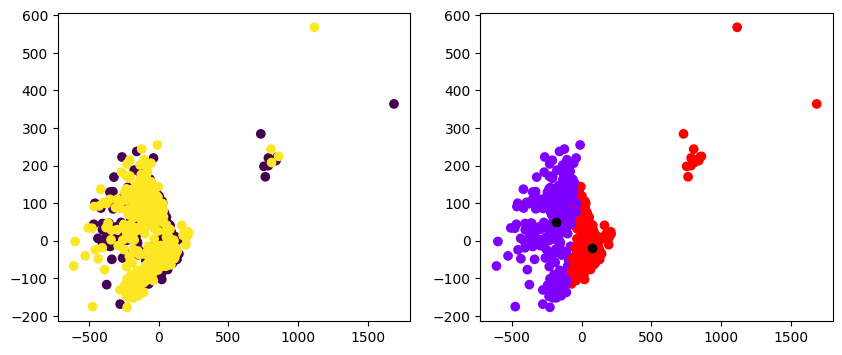

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=y)
plt.subplot(122)
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')

### <font color='#52F17F'> **9.3.2 Metricas para los diferentes Algoritmos de Clustering**</color> <a name="tema8">

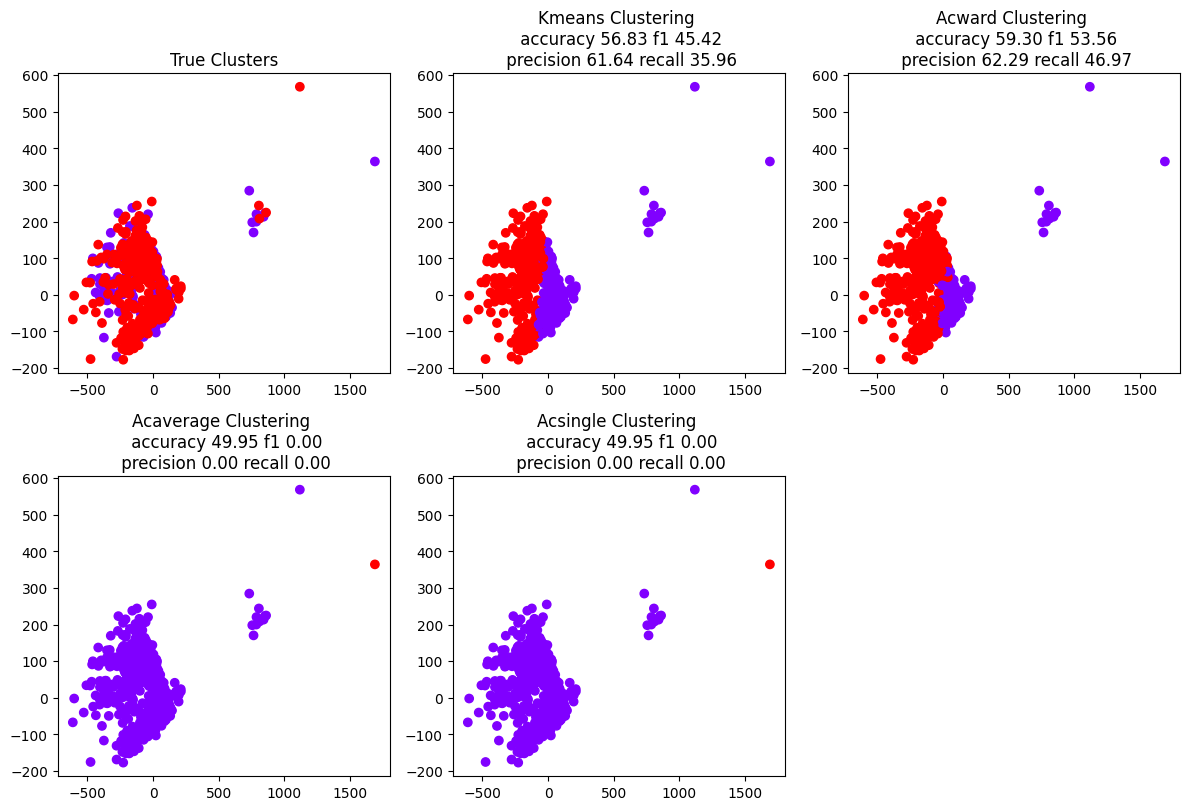

In [ ]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Incrementar la altura para acomodar 3 filas

num_algorithms = len(algorithms)
num_columns = (num_algorithms + 1 + 2) // 2  # Calcular el número de columnas necesarias

# Dibujar los verdaderos clusters
plt.subplot(3, num_columns, 1)  # Ajustar para incluir la gráfica de clusters verdaderos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
plt.title('True Clusters')

# Iterar sobre cada algoritmo y aplicar el clustering
for i, (name, alg) in enumerate(algorithms):
    # Aplicar el algoritmo de clustering
    clusters = alg.fit_predict(X)

    # Calcular métricas
    metrics = calculate_metrics(y, clusters)

    plt.subplot(3, num_columns, i + 2)
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='rainbow')

    # Título con el nombre del algoritmo y las métricas calculadas
    plt.title(f'{name.capitalize()} Clustering \n {metrics}')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()
plt.show()

#  <font color='#4C5FDA'> **10. Bibliografía**</font>

* librosa.stft — librosa 0.10.2dev documentation. (n.d.). https://librosa.org/doc/main/generated/librosa.stft.html
* Poojag. (2022, 14 agosto). Dysarthria Speech Classification using CNN. Kaggle. https://www.kaggle.com/code/poojag718/dysarthria-speech-classification-using-cnn
* Valerio Velardo - The Sound of AI. (2020, 17 septiembre). Extracting Mel Spectrograms with Python [Vídeo]. YouTube. https://www.youtube.com/watch?v=TdnVE5m3o_0
* Tong, H., Sharifzadeh, H., & McLoughlin, I. (2020). Automatic assessment of dysarthric severity level using audio-video cross-modal approach in deep learning.
* Ngiam, J., Khosla, A., Kim, M., Nam, J., Lee, H., & Ng, A. Y. (2011). Multimodal deep learning. In Proceedings of the 28th international conference on machine learning (ICML-11) (pp. 689-696).
* John Archila, Antoine Manzanera, Fabio Martínez. Mixed audio-video SPD networks for online classification of Parkinsonian speech patterns.
* GroupKFold. (s. f.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html
* StandardScaler. (s. f.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
* PyTorch. (2021, 12 abril). Training with PyTorch [Vídeo]. YouTube. https://www.youtube.com/watch?v=jF43_wj_DCQ
* Weights & Biases. (2020, 30 octubre). 🔥 Integrate Weights & Biases with PyTorch [Vídeo]. YouTube. https://www.youtube.com/watch?v=G7GH0SeNBMA
* Christianversloot. (s. f.). machine-learning-articles/how-to-use-k-fold-cross-validation-with-pytorch.md at main · christianversloot/machine-learning-articles. GitHub. https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
* Mangale, S. (2021, 15 diciembre). Scree Plot - SANCHITA MANGALE - Medium. Medium. https://sanchitamangale12.medium.com/scree-plot-733ed72c8608
* PCA. (s. f.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
* KMeans. (s. f.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans
* AgglomerativeClustering. (s. f.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html






